In [1]:

# !pip install lightgbm

In [39]:
import json, gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
from scipy.special import comb
from copy import deepcopy
import random
from tqdm import tqdm
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim


## Thoughts on how to reduce runtime: 

1. Use only interesting frames

Pseudo Code: 

```Python
interesting_frames = set()

for _, event in events_df.iterrows():
    if event["type.name"] in ["Pass", "Carry", "Shot"]:
        sec = event["second"] + 60 * event["minute"]
        window_start = sec - 5
        window_end = sec + 5

        # Convert seconds → frame indices
        frame_start = int(window_start * frame_rate)
        frame_end = int(window_end * frame_rate)

        for f in range(frame_start, frame_end + 1):
            interesting_frames.add(f) 
```

Then slice your players_df:

```Python
players_df_window = players_df[
    players_df["frameIdx"].isin(interesting_frames)
]
```

2. Use Random Sampling


In [3]:

TRACKING_DIR = pathlib.Path("tracking-compressed")
json_gz_paths = sorted(TRACKING_DIR.glob("tracking_*.json.gz"))

print(len(json_gz_paths), "tracking files found")

n_files = 250 # or set to len(json_gz_paths) to load all

# frames = []
# players = []
# used_match_ids = []  # <- store used match_ids here

# for file_idx, json_gz_path in enumerate(json_gz_paths[:n_files]):
#     match_id = json_gz_path.stem  # e.g. "tracking_g2444470"
#     used_match_ids.append(match_id)  # <- keep track of what's loaded

#     records = []

#     with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
#         for line in f:
#             records.append(json.loads(line))

#     for r in records:
#         f_data = {
#             "match_id": match_id,
#             "period": r["period"],
#             "frameIdx": r["frameIdx"],
#             "gameClock": r["gameClock"],
#             "lastTouch_team": r["lastTouch"],
#             "ball_x": r["ball"]["xyz"][0],
#             "ball_y": r["ball"]["xyz"][1],
#             "ball_z": r["ball"]["xyz"][2],
#         }
#         frames.append(f_data)

#         for side in ["homePlayers", "awayPlayers"]:
#             for p in r[side]:
#                 px, py, pz = p["xyz"]
#                 players.append({
#                     "match_id": match_id,
#                     "period": r["period"],
#                     "frameIdx": r["frameIdx"],
#                     "side": "home" if side == "homePlayers" else "away",
#                     "playerId": p["playerId"],
#                     "optaId": str(p["optaId"]),
#                     "number": p["number"],
#                     "x": px, "y": py, "z": pz,
#                     "speed": p["speed"],
#                 })

# # Convert to DataFrames
# frames_df = pd.DataFrame(frames)
# players_df = pd.DataFrame(players)
  
frames = []
players = []
used_match_ids = []

for file_idx, json_gz_path in enumerate(json_gz_paths[:n_files]):
    match_id = json_gz_path.stem
    used_match_ids.append(match_id)

    # First pass: count lines
    with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
        total_lines = sum(1 for _ in f)

    # Randomly select frame indices
    n_sampled_frames = 500
    sampled_indices = set(
        np.random.choice(
            total_lines,
            size=min(n_sampled_frames, total_lines),
            replace=False
        )
    )

    # Second pass: read only sampled frames
    with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i not in sampled_indices:
                continue

            r = json.loads(line)

            f_data = {
                "match_id": match_id,
                "period": r["period"],
                "frameIdx": r["frameIdx"],
                "gameClock": r["gameClock"],
                "lastTouch_team": r["lastTouch"],
                "ball_x": r["ball"]["xyz"][0],
                "ball_y": r["ball"]["xyz"][1],
                "ball_z": r["ball"]["xyz"][2],
            }
            frames.append(f_data)

            for side in ["homePlayers", "awayPlayers"]:
                for p in r[side]:
                    px, py, pz = p["xyz"]
                    players.append({
                        "match_id": match_id,
                        "period": r["period"],
                        "frameIdx": r["frameIdx"],
                        "side": "home" if side == "homePlayers" else "away",
                        "playerId": p["playerId"],
                        "optaId": str(p["optaId"]),
                        "number": p["number"],
                        "x": px, "y": py, "z": pz,
                        "speed": p["speed"],
                    })

frames_df = pd.DataFrame(frames)
players_df = pd.DataFrame(players)

1127 tracking files found


In [4]:
def sample_tracking_segments(players_df, frames_df,
                             num_segments=10,
                             segment_duration_sec=5,
                             frame_rate=25.0,
                             random_state=None):
    """
    Randomly samples time segments from tracking data.

    Returns:
        players_df_sampled, frames_df_sampled
    """

    sampled_frames = set()

    for (match_id, period), group in frames_df.groupby(["match_id", "period"]):

        max_frame = group["frameIdx"].max()
        total_seconds = max_frame / frame_rate

        if total_seconds < segment_duration_sec:
            continue  # skip short halves

        # Possible start times in seconds
        possible_starts = np.arange(
            0,
            total_seconds - segment_duration_sec,
            step=1
        )

        if len(possible_starts) == 0:
            continue

        rng = np.random.default_rng(random_state)
        chosen_starts_sec = rng.choice(
            possible_starts,
            size=min(num_segments, len(possible_starts)),
            replace=False
        )

        for start_sec in chosen_starts_sec:
            start_frame = int(start_sec * frame_rate)
            end_frame = start_frame + int(segment_duration_sec * frame_rate)

            frames_in_segment = range(start_frame, end_frame + 1)
            sampled_frames.update(
                (match_id, period, f) for f in frames_in_segment
            )

    # Filter players_df and frames_df
    sampled_frames_df = pd.DataFrame(
        list(sampled_frames),
        columns=["match_id", "period", "frameIdx"]
    )

    players_df_sampled = players_df.merge(
        sampled_frames_df,
        on=["match_id", "period", "frameIdx"],
        how="inner"
    )

    frames_df_sampled = frames_df.merge(
        sampled_frames_df,
        on=["match_id", "period", "frameIdx"],
        how="inner"
    )

    return players_df_sampled, frames_df_sampled

# Sample tracking segments
players_df, frames_df = sample_tracking_segments(
    players_df,
    frames_df,
    num_segments=10,
    segment_duration_sec=5,
    random_state=42
)

In [5]:
def extract_event_metadata(events_path):
    teams = set()
    match_date = None

    with open(events_path, "r", encoding="utf-8-sig") as f:
        for line in f:
            obj = json.loads(line)
            
            # Grab match date
            if match_date is None and "match_date" in obj:
                match_date = obj["match_date"]

            # Grab team names
            if "team" in obj and obj["team"] is not None:
                team_name = obj["team"]["name"]
                teams.add(team_name)
            if "possession_team" in obj and obj["possession_team"] is not None:
                team_name = obj["possession_team"]["name"]
                teams.add(team_name)

    return {
        "events_file": str(events_path),
        "match_date": match_date,
        "team_names": list(teams),
    }

# Assume your event files are in a directory named 'events'
EVENTS_DIR = pathlib.Path("statsbomb_pl_data")
event_files = sorted(EVENTS_DIR.glob("*.json"))

event_metadata_records = []

for event_file in event_files:
    meta = extract_event_metadata(event_file)
    event_metadata_records.append(meta)

event_meta_df = pd.DataFrame(event_metadata_records)

print(event_meta_df.head())

                      events_file  match_date  \
0  statsbomb_pl_data/3837230.json  2022-08-05   
1  statsbomb_pl_data/3837231.json  2022-08-06   
2  statsbomb_pl_data/3837232.json  2022-08-07   
3  statsbomb_pl_data/3837233.json  2022-08-06   
4  statsbomb_pl_data/3837234.json  2022-08-06   

                                team_names  
0                [Arsenal, Crystal Palace]  
1  [Wolverhampton Wanderers, Leeds United]  
2              [Brentford, Leicester City]  
3    [Newcastle United, Nottingham Forest]  
4         [Tottenham Hotspur, Southampton]  


In [6]:

# Collect all metadata files
metadata_dir = pathlib.Path("metadata_SecondSpectrum")
all_metadata_files = list(metadata_dir.glob("*.json"))

tracking_meta_records = []

for path in all_metadata_files:
    with open(path, "r", encoding="utf-8-sig") as f:
        meta = json.load(f)

    # Build match_date from year, month, day
    if all(k in meta for k in ["year", "month", "day"]):
        match_date = f"{meta['year']:04}-{meta['month']:02}-{meta['day']:02}"
    else:
        match_date = None

    # Parse teams from description
    desc = meta.get("description", "")
    home_team, away_team = None, None
    if " - " in desc:
        teams_part = desc.split(":")[0].strip()
        home_team, away_team = teams_part.split(" - ")

    # Get tracking suffix from filename
    if path.stem.startswith("metadata_g"):
        suffix = path.stem.split("_")[1]
    else:
        suffix = path.stem.split("_")[0]

    tracking_meta_records.append({
        "metadata_path": str(path),
        "tracking_suffix": suffix,
        "match_date": match_date,
        "home_team": home_team,
        "away_team": away_team,
    })

tracking_meta_df = pd.DataFrame(tracking_meta_records)

print(tracking_meta_df.head())

                                       metadata_path tracking_suffix  \
0     metadata_SecondSpectrum/metadata_g2444536.json        g2444536   
1  metadata_SecondSpectrum/g2292852_SecondSpectru...        g2292852   
2     metadata_SecondSpectrum/metadata_g2444473.json        g2444473   
3  metadata_SecondSpectrum/g2293073_SecondSpectru...        g2293073   
4  metadata_SecondSpectrum/g2367750_SecondSpectru...        g2367750   

   match_date home_team away_team  
0  2024-10-05       EVE       NEW  
1  2022-08-30       CRY       BRE  
2  2024-08-17       IPS       LIV  
3  2023-03-12       FUL       ARS  
4  2024-01-30       FUL       EVE  


In [7]:
team_code_map = {'FUL': 'Fulham',
                'BRE': 'Brentford',
                'CRY': 'Crystal Palace', 
                'TOT': 'Tottenham Hotspur', 
                'BOU': 'AFC Bournemouth', 
                'SOU': 'Southampton',
                'AVL': 'Aston Villa', 
                'WHU': 'West Ham United', 
                'MUN': 'Manchester United',
                'ARS': 'Arsenal', 
                'LEI': 'Leicester City',
                'NEW': 'Newcastle United',
                'BHA': 'Brighton & Hove Albion',
                'IPS': 'Ipswich Town', 
                'EVE': 'Everton', 
                'LIV': 'Liverpool',
                'LEE': 'Leeds United', 
                'NOT': 'Nottingham Forest',
                'MCI': 'Manchester City', 
                'WOL': 'Wolverhampton Wanderers',
                'SHU': 'Sheffield United',
                'CHE': 'Chelsea', 
                'LUT': 'Luton Town', 
                'BUR': 'Burnley'}

print(" TEAM CODE MAP:")
print(team_code_map)

 TEAM CODE MAP:
{'FUL': 'Fulham', 'BRE': 'Brentford', 'CRY': 'Crystal Palace', 'TOT': 'Tottenham Hotspur', 'BOU': 'AFC Bournemouth', 'SOU': 'Southampton', 'AVL': 'Aston Villa', 'WHU': 'West Ham United', 'MUN': 'Manchester United', 'ARS': 'Arsenal', 'LEI': 'Leicester City', 'NEW': 'Newcastle United', 'BHA': 'Brighton & Hove Albion', 'IPS': 'Ipswich Town', 'EVE': 'Everton', 'LIV': 'Liverpool', 'LEE': 'Leeds United', 'NOT': 'Nottingham Forest', 'MCI': 'Manchester City', 'WOL': 'Wolverhampton Wanderers', 'SHU': 'Sheffield United', 'CHE': 'Chelsea', 'LUT': 'Luton Town', 'BUR': 'Burnley'}


In [8]:
tracking_meta_df["home_team_full"] = tracking_meta_df["home_team"].map(team_code_map)
tracking_meta_df["away_team_full"] = tracking_meta_df["away_team"].map(team_code_map)

tracking_meta_long = pd.concat([
    tracking_meta_df.assign(team_name=tracking_meta_df["home_team_full"]),
    tracking_meta_df.assign(team_name=tracking_meta_df["away_team_full"]),
])

tracking_meta_long["key"] = (
    tracking_meta_long["match_date"].fillna("") + "_" +
    tracking_meta_long["team_name"].fillna("")
)

event_meta_exploded = event_meta_df.explode("team_names")
event_meta_exploded["team_name"] = event_meta_exploded["team_names"].fillna("")

event_meta_exploded["key"] = (
    event_meta_exploded["match_date"].fillna("") + "_" +
    event_meta_exploded["team_name"].fillna("")
)

event_tracking_df = event_meta_exploded.merge(
    tracking_meta_long,
    on="key",
    how="left",
    suffixes=("", "_tracking")
)

print(event_tracking_df.head())

                      events_file  match_date               team_names  \
0  statsbomb_pl_data/3837230.json  2022-08-05                  Arsenal   
1  statsbomb_pl_data/3837230.json  2022-08-05           Crystal Palace   
2  statsbomb_pl_data/3837231.json  2022-08-06  Wolverhampton Wanderers   
3  statsbomb_pl_data/3837231.json  2022-08-06             Leeds United   
4  statsbomb_pl_data/3837232.json  2022-08-07                Brentford   

                 team_name                                 key  \
0                  Arsenal                  2022-08-05_Arsenal   
1           Crystal Palace           2022-08-05_Crystal Palace   
2  Wolverhampton Wanderers  2022-08-06_Wolverhampton Wanderers   
3             Leeds United             2022-08-06_Leeds United   
4                Brentford                2022-08-07_Brentford   

                                       metadata_path tracking_suffix  \
0  metadata_SecondSpectrum/g2292810_SecondSpectru...        g2292810   
1  metadata_Se

In [9]:
event_tracking_df_clean = (
    event_tracking_df
    .dropna(subset=["tracking_suffix"])
    .drop_duplicates(subset=["events_file"])
    .reset_index(drop=True)
)
print(event_tracking_df_clean.head())

                      events_file  match_date               team_names  \
0  statsbomb_pl_data/3837230.json  2022-08-05                  Arsenal   
1  statsbomb_pl_data/3837231.json  2022-08-06  Wolverhampton Wanderers   
2  statsbomb_pl_data/3837232.json  2022-08-07                Brentford   
3  statsbomb_pl_data/3837233.json  2022-08-06         Newcastle United   
4  statsbomb_pl_data/3837234.json  2022-08-06        Tottenham Hotspur   

                 team_name                                 key  \
0                  Arsenal                  2022-08-05_Arsenal   
1  Wolverhampton Wanderers  2022-08-06_Wolverhampton Wanderers   
2                Brentford                2022-08-07_Brentford   
3         Newcastle United         2022-08-06_Newcastle United   
4        Tottenham Hotspur        2022-08-06_Tottenham Hotspur   

                                       metadata_path tracking_suffix  \
0  metadata_SecondSpectrum/g2292810_SecondSpectru...        g2292810   
1  metadata_Se

In [10]:
# Add absolute seconds column
def add_event_timestamps(events_df):
    events_df["minute"] = events_df["minute"].fillna(0).astype(int)
    events_df["second"] = events_df["second"].fillna(0).astype(int)

    if "milliseconds" in events_df.columns:
        events_df["milliseconds"] = events_df["milliseconds"].fillna(0).astype(int)
    else:
        events_df["milliseconds"] = 0

    events_df["seconds_period"] = (
        events_df["minute"] * 60 +
        events_df["second"] +
        events_df["milliseconds"] / 1000
    )

    return events_df

def match_events_to_frames(events_df, frames_df_match):
    """
    Assigns nearest frameIdx to each event.
    """
    period_to_frame_times = {}
    for period, group in frames_df_match.groupby("period"):
        period_to_frame_times[period] = group[["seconds_period", "frameIdx"]].sort_values("seconds_period")

    assigned_frames = []
    for _, e in events_df.iterrows():
        period = e["period"]
        seconds_event = e["seconds_period"]

        if period not in period_to_frame_times:
            assigned_frames.append(None)
            continue

        times = period_to_frame_times[period]["seconds_period"].values
        frames = period_to_frame_times[period]["frameIdx"].values

        # Find closest frame
        idx = np.argmin(np.abs(times - seconds_event))
        assigned_frame = frames[idx]
        assigned_frames.append(assigned_frame)

    events_df["frameIdx"] = assigned_frames
    return events_df


def find_events_during_run(run_df, events_df):
    """
    Given a single run DataFrame and events_df
    returns list of events that overlap this run
    """
    period = run_df["period"].iloc[0]
    start_frame = run_df["frameIdx"].min()
    end_frame = run_df["frameIdx"].max()

    overlapping_events = events_df[
        (events_df["period"] == period) &
        (events_df["frameIdx"] >= start_frame) &
        (events_df["frameIdx"] <= end_frame)
    ]
    return overlapping_events

# for _, row in event_tracking_df_clean.iterrows():
#     events_path = row["events_file"]
#     tracking_suffix = row["tracking_suffix"]
#     tracking_match_id = f"tracking_{tracking_suffix}"

#     # Slice tracking data for this match
#     frames_df_match = frames_df[frames_df["match_id"] == tracking_match_id]
#     players_df_match = players_df[players_df["match_id"] == tracking_match_id]

#     print("=" * 100)
#     print(f" MATCH FOUND:")
#     print(f"→ Events file:   {events_path}")
#     print(f"→ Tracking file: {tracking_match_id}.json.gz")
#     print(f"→ Match Date:    {row['match_date']}")
#     print(f"→ Home Team:     {row['home_team']}")
#     print(f"→ Away Team:     {row['away_team']}")
#     print(f"→ Number of tracking frames: {len(frames_df_match)}")
#     print(f"→ Number of tracking player rows: {len(players_df_match)}")
#     print("=" * 100)

#     # Load events JSON
#     with open(events_path, "r", encoding="utf-8-sig") as f:
#         event_rows = [json.loads(line) for line in f]

#     events_df = pd.DataFrame(event_rows)
#     #print(events_df.head())

#         # Add absolute seconds column
#     events_df = add_event_timestamps(events_df)

#     # Compute seconds for frames
#     PERIOD_DURATION_SEC = 45 * 60
#     frames_df_match["seconds_period"] = PERIOD_DURATION_SEC - frames_df_match["gameClock"]

#     # Assign nearest frameIdx to each event
#     events_df = match_events_to_frames(events_df, frames_df_match)

#     # Find overlapping events for each run in this match
#     runs_in_match = final_runs_df[final_runs_df["match_id"] == tracking_match_id]

#     for run_id, run_df in runs_in_match.groupby("run_id"):
#         overlapping_events = find_events_during_run(run_df, events_df)

#         if not overlapping_events.empty:
#             print(f"Run {run_id} overlaps with {len(overlapping_events)} events:")
#             print(overlapping_events[["type", "minute", "second", "player", "team"]].head())

# events_dfs_by_match = {}

# for _, row in event_tracking_df_clean.iterrows():
#     events_path = row["events_file"]
#     tracking_suffix = row["tracking_suffix"]
#     tracking_match_id = f"tracking_{tracking_suffix}"

#     # Slice tracking data for this match
#     frames_df_match = frames_df[frames_df["match_id"] == tracking_match_id]
#     players_df_match = players_df[players_df["match_id"] == tracking_match_id]

#     # print("=" * 100)
#     # print(f" MATCH FOUND:")
#     # print(f"→ Events file:   {events_path}")
#     # print(f"→ Tracking file: {tracking_match_id}.json.gz")
#     # print(f"→ Match Date:    {row['match_date']}")
#     # print(f"→ Home Team:     {row['home_team']}")
#     # print(f"→ Away Team:     {row['away_team']}")
#     # print(f"→ Number of tracking frames: {len(frames_df_match)}")
#     # print(f"→ Number of tracking player rows: {len(players_df_match)}")
#     # print("=" * 100)

#     # Load events JSON
#     with open(events_path, "r", encoding="utf-8-sig") as f:
#         event_rows = [json.loads(line) for line in f]
#     events_df = pd.DataFrame(event_rows)
    
#     # add timestamps
#     events_df = add_event_timestamps(events_df)

#     # attach frameIdx
#     frames_df_match["seconds_period"] = 45*60 - frames_df_match["gameClock"]
#     events_df = match_events_to_frames(events_df, frames_df_match)

#     # store this DataFrame for later:
#     events_dfs_by_match[tracking_match_id] = events_df

import os

if os.path.exists("events_dfs_by_match.joblib"):
    events_dfs_by_match = joblib.load("events_dfs_by_match.joblib")
    print(" Loaded precomputed events_dfs_by_match.")
else:
    # run original block:
    events_dfs_by_match = {}

    for _, row in event_tracking_df_clean.iterrows():
        events_path = row["events_file"]
        tracking_suffix = row["tracking_suffix"]
        tracking_match_id = f"tracking_{tracking_suffix}"

        frames_df_match = frames_df[frames_df["match_id"] == tracking_match_id]
        players_df_match = players_df[players_df["match_id"] == tracking_match_id]

        with open(events_path, "r", encoding="utf-8-sig") as f:
            event_rows = [json.loads(line) for line in f]

        events_df = pd.DataFrame(event_rows)
        events_df = add_event_timestamps(events_df)

        frames_df_match["seconds_period"] = 45*60 - frames_df_match["gameClock"]
        events_df = match_events_to_frames(events_df, frames_df_match)

        events_dfs_by_match[tracking_match_id] = events_df

    joblib.dump(events_dfs_by_match, "events_dfs_by_match.joblib")
    print(" Saved events_dfs_by_match to disk.")


    
    
# REMEMBER TO ADD THIS AFTER FINAL_RUNS_DF IS DEFINED
# for match_id, events_df in events_dfs_by_match.items():
#     runs_in_match = final_runs_df[final_runs_df["match_id"] == match_id]

#     for run_id, run_df in runs_in_match.groupby("run_id"):
#         overlapping_events = find_events_during_run(run_df, events_df)

#         if not overlapping_events.empty:
#             print(f"Run {run_id} overlaps with {len(overlapping_events)} events:")
#             print(overlapping_events[["type", "minute", "second", "player", "team"]].head())

 Loaded precomputed events_dfs_by_match.


In [11]:
sample_match_id = list(events_dfs_by_match.keys())[0]

# Grab its DataFrame
events_df = events_dfs_by_match[sample_match_id]

# View basic info
#print(events_df.head(20))
print(events_df.columns)
print(events_df.shape)

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'obv_for_after',
       'obv_for_before', 'obv_for_net', 'obv_against_after',
       'obv_against_before', 'obv_against_net', 'obv_total_net', 'team',
       'duration', 'tactics', 'load_datetime', 'user', 'match_date',
       'match_id', 'pipeline_run_id', 'extraction_timestamp', 'related_events',
       'player', 'position', 'location', 'pass', 'carry', 'ball_receipt',
       'under_pressure', 'duel', 'counterpress', 'interception', 'out',
       'dribble', 'ball_recovery', 'off_camera', 'shot', 'goalkeeper',
       'clearance', 'block', 'foul_committed', 'foul_won', 'miscontrol',
       'substitution', 'milliseconds', 'seconds_period', 'frameIdx'],
      dtype='object')
(3806, 52)


In [12]:
# Step 1: Extract suffixes like "g2444470" from used tracking files
used_match_suffixes = [match_id.split("_", 1)[1].replace(".json", "") for match_id in used_match_ids]

# Step 2: Gather metadata file paths from both formats
metadata_dir = pathlib.Path("metadata_SecondSpectrum")
all_metadata_files = list(metadata_dir.glob("*.json"))

# Build map: match_suffix (e.g., "g2444470") → metadata_path
metadata_file_map = {}
for path in all_metadata_files:
    filename = path.name
    if filename.startswith("metadata_g") and filename.endswith(".json"):
        suffix = filename.split("_")[1].split(".")[0]  # 'g2444470'
    elif filename.endswith("_SecondSpectrum_Metadata.json"):
        suffix = filename.split("_")[0]  # 'g2444470'
    else:
        continue  # skip non-matching files
    metadata_file_map[suffix] = path

# Build a lookup DataFrame linking tracking suffixes to match date and teams
tracking_meta_records = []
for suffix, metadata_path in metadata_file_map.items():
    with open(metadata_path, "r", encoding="utf-8-sig") as f:
        meta = json.load(f)
    tracking_meta_records.append({
        "match_date": meta.get("matchDate"),
        "home_team": meta.get("homeTeamName"),
        "away_team": meta.get("awayTeamName"),
        "tracking_suffix": suffix,
        "metadata_path": str(metadata_path),
    })


# Step 3: Load metadata and build lookup for used matches
opta_meta_lookup = {}

for suffix in used_match_suffixes:
    metadata_path = metadata_file_map.get(suffix)
    if not metadata_path:
        print(f" No metadata found for match {suffix}")
        continue

    with open(metadata_path, "r", encoding="utf-8-sig") as f:
        meta = json.load(f)

    match_id = f"tracking_{suffix}"  # same format as tracking match_id

    for side, team in [("homePlayers", "home"), ("awayPlayers", "away")]:
        for p in meta.get(side, []):
            key = (match_id, str(p["optaId"]))
            opta_meta_lookup[key] = {
                "player_name": p.get("name"),
                "position": p.get("position"),
                "team_role": team,
            }

print(f" Loaded metadata for {len(opta_meta_lookup)} players.")

meta_df = pd.DataFrame([
    {
        "match_id": match_id,
        "optaId": opta_id,
        "player_name": info["player_name"],
        "position": info["position"],
        "team_role": info["team_role"],
    }
    for (match_id, opta_id), info in opta_meta_lookup.items()
])

players_df["match_id_clean"] = players_df["match_id"].str.replace(".json", "", regex=False)

# Merge using match_id and optaId as keys
players_df = players_df.merge(
    meta_df,
    how="left",
    left_on=["match_id_clean", "optaId"],
    right_on=["match_id", "optaId"]
)

players_df.drop(columns=["match_id_clean", "match_id_y"], inplace=True)
players_df.rename(columns={"match_id_x": "match_id"}, inplace=True)


 Loaded metadata for 9992 players.


In [13]:
# Segmenting Runs (across multiple matches)
def segment_runs(players_df, speed_threshold=2.0):
    """
    Segments continuous runs for each player within each match and period
    when speed exceeds a threshold.
    """
    runs = []
    for (match_id, period, playerId), group in players_df.groupby(["match_id", "period", "playerId"]):
        group = group.sort_values("frameIdx")
        current_run = []
        for _, row in group.iterrows():
            if row["speed"] > speed_threshold:
                current_run.append(row)
            elif current_run:
                runs.append(pd.DataFrame(current_run))
                current_run = []
        if current_run:
            runs.append(pd.DataFrame(current_run))
    return runs

def filter_off_ball_runs_with_distance(runs_list, frames_df, players_df, min_distance=3.0):
    """
    Filters runs to keep only those where:
    - The player never touched the ball (not lastTouch)
    - The player is always at least `min_distance` away from the ball
    """
    frame_last_touch = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch_team"].to_dict()
    ball_positions = frames_df.set_index(["match_id", "period", "frameIdx"])[["ball_x", "ball_y"]].to_dict("index")
    
    off_ball_runs = []

    for run_df in runs_list:
        player_id = run_df["playerId"].iloc[0]
        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        frame_idxs = run_df["frameIdx"].values

        is_off_ball = True
        for frame_idx in frame_idxs:
            key = (match_id, period, frame_idx)

            # Check lastTouch
            if frame_last_touch.get(key) == player_id:
                is_off_ball = False
                break

            # Check distance from ball
            ball_pos = ball_positions.get(key)
            if ball_pos is None:
                continue  # Skip frames with missing ball info

            player_pos = run_df[run_df["frameIdx"] == frame_idx][["x", "y"]].values
            if player_pos.size == 0:
                continue

            dist = np.linalg.norm(player_pos[0] - np.array([ball_pos["ball_x"], ball_pos["ball_y"]]))
            if dist < min_distance:
                is_off_ball = False
                break

        if is_off_ball:
            off_ball_runs.append(run_df)

    return off_ball_runs

runs_list = segment_runs(players_df)
print(f"Total runs segmented: {len(runs_list)}")

runs_list = filter_off_ball_runs_with_distance(runs_list, frames_df, players_df, min_distance=3.0)
print(f"Total off-ball runs (with min distance): {len(runs_list)}")

# Annotate each run with player metadata
annotated_runs = []

for run_df in runs_list:
    # Make a copy of the run to avoid modifying in-place
    run_df = run_df.copy()

    # Extract metadata from the first row (same for entire run)
    meta_fields = ["playerId", "optaId", "match_id", "player_name", "position", "team_role"]
    for field in meta_fields:
        run_df[field] = run_df.iloc[0][field]

    annotated_runs.append(run_df)

# Assign a unique run_id to each run
for i, run_df in enumerate(annotated_runs):
    run_df["run_id"] = i

# Optional: Combine into one dataframe
all_runs_df = pd.concat(annotated_runs, ignore_index=True)

# Preview
print(all_runs_df[["player_name", "position", "team_role", "x", "y", "speed"]].head())

Total runs segmented: 6978
Total off-ball runs (with min distance): 6467
  player_name position team_role      x      y  speed
0   J. Mateta      SUB      home -21.45  -4.17   3.34
1   J. Mateta      SUB      home -29.21  -9.85   3.26
2   T. Partey      CDM      away -21.83 -17.53   4.08
3    M. Guehi      LCB      home   1.01 -13.29   3.20
4     W. Zaha       LW      home -39.56 -10.85   3.72


In [14]:
# Def mirror function
def mirror_group(group):

    y_mean = group["y"].mean()
    if y_mean < 0:
        group["y_mirror"] = -group["y"]
    else:
        group["y_mirror"] = group["y"]
    group["x_mirror"] = group["x"]


    return group

def should_flip_x(team_role, period):
    """
    Returns True if this team in this period attacks right-to-left.
    """
    if period == 1:
        return team_role == "away"
    elif period == 2:
        return team_role == "home"
    else:
        return False  # Just in case

# Apply mirroring per run
all_runs_df = all_runs_df.groupby("run_id", group_keys=False).apply(mirror_group)

/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_75067/2786365659.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_runs_df = all_runs_df.groupby("run_id", group_keys=False).apply(mirror_group)


In [15]:
# Step 1: Precompute centroids for all frames and both teams (excluding goalkeeper)
players_df["number"] = players_df["number"].astype(int)

centroid_dict = {}
for (match_id, period, frame_idx), group in players_df.groupby(["match_id", "period", "frameIdx"]):
    for side in ["home", "away"]:
        team_players = group[(group["side"] == side) & (group["number"] != 1)]
        centroid = team_players[["x", "y"]].mean().values if not team_players.empty else np.array([0.0, 0.0])
        centroid_dict[(match_id, period, frame_idx, side)] = centroid

print(f"Centroids computed for {len(centroid_dict)} frame-side combinations.")
print(list(centroid_dict.items())[:5])  # show first few for inspection

frame_last_touch_team = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch_team"].to_dict()
player_side_lookup = players_df.set_index(["match_id", "period", "frameIdx", "playerId"])["side"].to_dict()

adjusted_runs_list = []

grouped = all_runs_df.groupby(["match_id", "period", "playerId", "run_id"], group_keys=False)

for _, run_df in grouped:
    run_df = run_df.sort_values("frameIdx")
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]
    start_frame = run_df["frameIdx"].iloc[0]

    team_centroid = np.array([0.0, 0.0])  # fallback default

    key = (match_id, period, start_frame)
    possession_side = frame_last_touch_team.get(key)

    team_role = run_df["team_role"].iloc[0]

    if possession_side is None: 
        in_possession = np.nan
        phase_of_play = np.nan
    else: 
        in_possession = (team_role == possession_side)
        phase_of_play = "attack" if in_possession else "defend" 

    run_df["in_possession"] = in_possession
    run_df["phase_of_play"] = phase_of_play

    # if possession_side is not None:
    #     team_centroid = centroid_dict.get((match_id, period, start_frame, possession_side), team_centroid)

    # Always compute centroid for this player's own team. As opposed to above where we used possession side.
    team_centroid = centroid_dict.get(
        (match_id, period, start_frame, team_role),
        np.array([0.0, 0.0])
    )

    #print(team_centroid)

    run_df["x_c"] = run_df["x"] - team_centroid[0]
    run_df["y_c"] = run_df["y"] - team_centroid[1]
    run_df["x_mirror_c"] = run_df["x_mirror"] - team_centroid[0]
    run_df["y_mirror_c"] = run_df["y_mirror"] - team_centroid[1]

    flip_x = should_flip_x(team_role, period)
    if flip_x:
        run_df["x_mirror"] = -run_df["x_mirror"]
        run_df["x_mirror_c"] = -run_df["x_mirror_c"]

    adjusted_runs_list.append(run_df)

final_runs_df = pd.concat(adjusted_runs_list, ignore_index=True)

Centroids computed for 2946 frame-side combinations.
[(('tracking_g2292810.json', 1, 48401, 'home'), array([ 9.76909091, 19.42727273])), (('tracking_g2292810.json', 1, 48401, 'away'), array([19.129, 19.464])), (('tracking_g2292810.json', 2, 109953, 'home'), array([-18.04909091,   2.18545455])), (('tracking_g2292810.json', 2, 109953, 'away'), array([-35.987,  -3.195])), (('tracking_g2292810.json', 2, 122037, 'home'), array([-9.40818182, -0.17818182]))]


In [16]:
# Overlapping runs

def extract_ball_carrier_df_fast(run_df, players_with_ball_df):
    """
    Fast version of extract_ball_carrier_df.
    """
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    frames = run_df["frameIdx"].unique()

    # Slice relevant frames for this run
    run_players = players_with_ball_df[
        (players_with_ball_df["match_id"] == match_id) &
        (players_with_ball_df["period"] == period) &
        (players_with_ball_df["frameIdx"].isin(frames))
    ]

    # Keep only teammates
    teammates = run_players[
        run_players["side"] == team_role
    ].copy()

    if teammates.empty:
        return None

    # Compute distance to ball
    teammates["dist_to_ball"] = np.linalg.norm(
        teammates[["x", "y"]].values - teammates[["ball_x", "ball_y"]].values,
        axis=1
    )

    # Find closest player in each frame
    idx_min_dist = teammates.groupby("frameIdx")["dist_to_ball"].idxmin()

    ball_carrier_df = teammates.loc[idx_min_dist]

    if ball_carrier_df.empty:
        return None
    else:
        return ball_carrier_df

def is_overlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0):
    """
    Checks if a run overlaps the ball carrier.
    Skips runs if the ball carrier changes during the run.
    """
    if ball_carrier_df is None:
        return False

    # Check how many unique carriers there were during this run
    unique_carriers = ball_carrier_df["playerId"].nunique()
    # Can look at subRuns later, but for now we assume one carrier per run
    if unique_carriers > 1:
        # Carrier changed mid-run; skip for safety
        return False

    # Proceed as before
    f_start = run_df["frameIdx"].iloc[0]
    f_end = run_df["frameIdx"].iloc[-1]

    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    carrier_start_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_start
    ]

    carrier_end_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_end
    ]

    if carrier_start_row.empty or carrier_end_row.empty:
        return False

    carrier_start = carrier_start_row.iloc[0][["x", "y"]].values
    carrier_end = carrier_end_row.iloc[0][["x", "y"]].values

    # Compute lateral offset (y-direction)
    delta_start_y = runner_start[1] - carrier_start[1]
    delta_end_y = runner_end[1] - carrier_end[1]

    # Check if runner switched sides outside the carrier
    overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

    # Check lateral distance threshold
    lateral_movement = abs(delta_end_y - delta_start_y)

    # Ensure overlap moves forward enough
    forward_distance = runner_end[0] - runner_start[0]

    return (
        overlap_side_change and
        lateral_movement > 2.0 and
        forward_distance > min_pass_distance
    )

In [17]:
# Underlapping



def is_underlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0):
    """
    Heuristic: detects underlapping runs where the runner cuts inside
    relative to the ball carrier.

    Returns True only if the ball carrier remains constant during the run.
    """
    if ball_carrier_df is None:
        return False

    # Check how many unique carriers there were during this run
    unique_carriers = ball_carrier_df["playerId"].nunique()
    if unique_carriers > 1:
        # Carrier changed mid-run; skip for safety
        return False

    # Proceed as before
    f_start = run_df["frameIdx"].iloc[0]
    f_end = run_df["frameIdx"].iloc[-1]

    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    carrier_start_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_start
    ]

    carrier_end_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_end
    ]

    if carrier_start_row.empty or carrier_end_row.empty:
        return False

    carrier_start = carrier_start_row.iloc[0][["x", "y"]].values
    carrier_end = carrier_end_row.iloc[0][["x", "y"]].values

    # Compute lateral offsets (y-difference)
    delta_start_y = runner_start[1] - carrier_start[1]
    delta_end_y = runner_end[1] - carrier_end[1]

    overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

    lateral_distance_start = abs(delta_start_y)
    lateral_distance_end = abs(delta_end_y)

    lateral_movement = lateral_distance_start - lateral_distance_end

    forward_distance = runner_end[0] - runner_start[0]

    # For underlap:
    # - sign change
    # - lateral distance reduced (runner cuts inside)
    # - forward enough
    return (
        overlap_side_change
        and lateral_movement > 1.0
        and forward_distance > min_pass_distance
    )

In [18]:
def is_diagonal_run(run_df, min_length=5.0, angle_min=20, angle_max=70):
    """
    Heuristic to detect diagonal runs.

    - Checks total length
    - Checks that the angle lies within a diagonal corridor

    Returns True if diagonal.
    """
    # Start and end positions
    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    delta_x = runner_end[0] - runner_start[0]
    delta_y = runner_end[1] - runner_start[1]

    # Total run distance
    total_distance = np.linalg.norm([delta_x, delta_y])
    if total_distance < min_length:
        return False

    # Compute angle in degrees
    angle_deg = np.degrees(np.arctan2(delta_y, delta_x))

    abs_angle = abs(angle_deg)

    # Check if angle is in diagonal corridor
    return angle_min <= abs_angle <= angle_max

In [19]:
# Define grid
x_edges = np.linspace(-52.5, 52.5, 4)   # splits pitch length into thirds
y_edges = np.linspace(-34, 34, 4)       # splits width into thirds

def get_zone(x, y, x_edges, y_edges):
    x_bin = np.digitize([x], x_edges)[0] - 1
    y_bin = np.digitize([y], y_edges)[0] - 1
    x_bin = min(max(x_bin, 0), len(x_edges)-2)
    y_bin = min(max(y_bin, 0), len(y_edges)-2)
    zone_idx = y_bin * (len(x_edges)-1) + x_bin + 1
    return zone_idx

# Build players_with_ball_df ONCE for all runs
players_with_ball_df = players_df.merge(
    frames_df[["match_id", "period", "frameIdx", "ball_x", "ball_y", "lastTouch_team"]],
    on=["match_id", "period", "frameIdx"],
    how="left",
    suffixes=("", "_ball")
)

zone_records = []

for run_id, run_df in final_runs_df.groupby("run_id"):

    # Mirrored & centered positions
    start_x_mirror_c = run_df["x_mirror_c"].iloc[0]
    start_y_mirror_c = run_df["y_mirror_c"].iloc[0]

    end_x_mirror_c = run_df["x_mirror_c"].iloc[-1]
    end_y_mirror_c = run_df["y_mirror_c"].iloc[-1]

    coords = run_df[["x", "y"]].values

    if coords.shape[0] < 2:
        run_length = 0.0
    else: 
        deltas = np.diff(coords, axis=0)
        segment_lengths = np.linalg.norm(deltas, axis=1)
        run_length = np.sum(segment_lengths)

    mean_speed = run_df["speed"].mean()
    max_speed = run_df["speed"].max()

    dx = end_x_mirror_c - start_x_mirror_c
    dy = end_y_mirror_c - start_y_mirror_c

    run_angle_rad = np.arctan2(dy, dx)
    run_angle_deg = np.degrees(run_angle_rad)

    run_forward = dx > 0  # True if run is forward (right side of pitch)
    
    start_zone = get_zone(start_x_mirror_c, start_y_mirror_c, x_edges, y_edges)
    end_zone = get_zone(end_x_mirror_c, end_y_mirror_c, x_edges, y_edges)

    # Absolute pitch positions
    start_x_abs = run_df["x"].iloc[0]
    start_y_abs = run_df["y"].iloc[0]

    end_x_abs = run_df["x"].iloc[-1]
    end_y_abs = run_df["y"].iloc[-1]

    start_zone_abs = get_zone(start_x_abs, start_y_abs, x_edges, y_edges)
    end_zone_abs = get_zone(end_x_abs, end_y_abs, x_edges, y_edges)

    phase_of_play = run_df["phase_of_play"].iloc[0]
    in_possession = run_df["in_possession"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    position = run_df["position"].iloc[0]

    # Extract ball carrier df
    ball_carrier_df = extract_ball_carrier_df_fast(
        run_df, players_with_ball_df
    )
    
    # Check overlapping run
    overlapping = is_overlapping_run(run_df, ball_carrier_df)
    underlapping = is_underlapping_run(run_df, ball_carrier_df)
    is_diag = is_diagonal_run(run_df)

    zone_records.append({
        "run_id": run_id,
        "start_zone": start_zone,
        "end_zone": end_zone,
        "start_zone_absolute": start_zone_abs,
        "end_zone_absolute": end_zone_abs,
        "phase_of_play": phase_of_play,
        "in_possession": in_possession,
        "team_role": team_role,
        "position": position,
        "run_length_m": run_length,
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "run_angle_deg": run_angle_deg,
        "run_forward": run_forward,
        "tactical_overlap": overlapping,
        "tactical_underlap": underlapping,
        "tactical_diagonal": is_diag
    })

zones_df = pd.DataFrame(zone_records)
print(zones_df.head())

   run_id  start_zone  end_zone  start_zone_absolute  end_zone_absolute  \
0       0           5         6                    4                  4   
1       1           8         8                    1                  1   
2       2           8         8                    2                  2   
3       3           6         6                    4                  4   
4       4           5         5                    4                  4   

  phase_of_play  in_possession team_role position  run_length_m  mean_speed  \
0        attack           True      home      SUB      9.616652        3.30   
1        defend          False      away      CDM      0.000000        4.08   
2        attack           True      home      LCB      0.000000        3.20   
3        defend          False      home       LW      0.000000        3.72   
4        attack           True      home       LW      0.000000        4.72   

   max_speed  run_angle_deg  run_forward  tactical_overlap  tactical_under

In [20]:
# Equation (5): Bézier basis function
def bernstein_poly(p, P, t):
    return comb(P - 1, p) * (t**p) * ((1 - t)**(P - 1 - p))

# Equation (7): Design matrix for Bézier fitting
def bezier_design_matrix(num_points, num_control_points):
    t_vals = np.linspace(0, 1, num_points)
    X = np.stack([bernstein_poly(p, num_control_points, t_vals) for p in range(num_control_points)], axis=1)
    return X  # shape: [num_points, num_control_points]

# Equation (6): Fit Bézier curve via least squares
def fit_bezier_curve(coords, num_control_points):
    """
    coords: shape [N, 2] — sequence of (x, y) points
    returns: control_points [P, 2]
    """
    N = coords.shape[0]
    X = bezier_design_matrix(N, num_control_points)  # shape [N, P]
    
    # Solve least squares for x and y separately
    theta_x, _, _, _ = np.linalg.lstsq(X, coords[:, 0], rcond=None)
    theta_y, _, _, _ = np.linalg.lstsq(X, coords[:, 1], rcond=None)
    
    control_points = np.stack([theta_x, theta_y], axis=1)  # shape: [P, 2]
    return control_points

# Equation (4): Evaluate Bézier curve at t using control points θ
def evaluate_bezier_curve(control_points, num_points=50):
    """
    Returns sampled points along the Bézier curve.
    """
    P = control_points.shape[0]
    X = bezier_design_matrix(num_points, P)  # shape [num_points, P]
    curve = X @ control_points  # shape: [num_points, 2]
    return curve

In [21]:
def resample_coords(coords, num_points=50):
    from scipy.interpolate import interp1d
    if len(coords) < 2:
        return np.tile(coords[0], (num_points, 1))  # Edge case
    distances = np.cumsum(np.linalg.norm(np.diff(coords, axis=0), axis=1))
    distances = np.insert(distances, 0, 0.0)
    total_length = distances[-1]
    if total_length == 0:
        return np.tile(coords[0], (num_points, 1))
    normalized_dist = distances / total_length
    interp_func = interp1d(normalized_dist, coords, axis=0, kind='linear')
    uniform_dist = np.linspace(0, 1, num_points)
    return interp_func(uniform_dist)

def compute_l1_distance(traj, bezier_curve):
    """
    traj, bezier_curve: both of shape [num_points, 2]
    """
    return np.mean(np.abs(traj - bezier_curve))  # L1 averaged over all points and dimensions

In [22]:
max_iterations = 20 # only 1 iteration for now (for debugging)
tolerance = 1e-3  # Minimum improvement in objective to continue
num_points = 50
num_control_points = 4
k_clusters = 70

# Initialize cluster centers (Bézier curves)
random.seed(42)
initial_centroids = random.sample(adjusted_runs_list, k_clusters)
cluster_control_points = []

for run in initial_centroids:
    coords = run[["x_mirror_c", "y_mirror_c"]].values
    control_pts = fit_bezier_curve(coords, num_control_points)
    cluster_control_points.append(control_pts)

cluster_control_points = np.array(cluster_control_points)
previous_objective = float('inf')

for it in range(max_iterations):
    # Assignment step
    assignments = []
    objective_distances = []

    for run_id, run_df in final_runs_df.groupby("run_id"):
        coords = run_df[["x_mirror_c", "y_mirror_c"]].values
        # resampled_coords = resample_coords(coords, num_points=num_points)

        resampled_coords = resample_coords(coords, num_points=num_points)
        if resampled_coords is None:
            continue  # skip bad run

        min_dist = float("inf")
        assigned_cluster = -1

        for cluster_idx, control_pts in enumerate(cluster_control_points):
            bezier_curve = evaluate_bezier_curve(control_pts, num_points=num_points)
            dist = compute_l1_distance(resampled_coords, bezier_curve)
            if dist < min_dist:
                min_dist = dist
                assigned_cluster = cluster_idx

        # assignments.append(assigned_cluster)

            # Save metadata + cluster assignment
        assignments.append({
            "run_id": run_id,
            "assigned_cluster": assigned_cluster,
            "min_distance": min_dist,
            "playerId": run_df["playerId"].iloc[0],
            "player_name": run_df["player_name"].iloc[0],
            "position": run_df["position"].iloc[0],
            "team_role": run_df["team_role"].iloc[0],
            "match_id": run_df["match_id"].iloc[0],
        })

        assignments_df = pd.DataFrame(assignments)

        #print(assignments_df.head())

        objective_distances.append(min_dist)

    objective = np.mean(objective_distances)
    print(f"Iteration {it}: Mean objective = {objective:.4f}")

    # Check for convergence
    improvement = previous_objective - objective
    if improvement < tolerance:
        print(f"Converged (Δ={improvement:.6f}) at iteration {it}")
        break
    previous_objective = objective

    # Update step
    new_cluster_control_points = []

    for cluster_idx in range(k_clusters):
        #assigned_indices = [i for i, a in enumerate(assignments) if a == cluster_idx]
        assigned_indices = [i for i, a in enumerate(assignments) if a["assigned_cluster"] == cluster_idx]
        if not assigned_indices:
            new_cluster_control_points.append(cluster_control_points[cluster_idx])
            continue

        cluster_coords = []
        for idx in assigned_indices:
            run_id = assignments_df.loc[idx, "run_id"]
            #run_df = all_runs_df[all_runs_df["run_id"] == run_id]
            run_df = final_runs_df[final_runs_df["run_id"] == run_id]

            coords = run_df[["x_mirror_c", "y_mirror_c"]].values
            resampled = resample_coords(coords, num_points=num_points)
            # cluster_coords.append(resampled)
            if resampled is not None:
                cluster_coords.append(resampled)

        cluster_coords = np.stack(cluster_coords, axis=0)
        mean_coords = np.mean(cluster_coords, axis=0)
        new_control_pts = fit_bezier_curve(mean_coords, num_control_points)
        new_cluster_control_points.append(new_control_pts)

    cluster_control_points = np.array(new_cluster_control_points)

Iteration 0: Mean objective = 6.2773
Iteration 1: Mean objective = 3.5178
Iteration 2: Mean objective = 3.1896
Iteration 3: Mean objective = 3.0222
Iteration 4: Mean objective = 2.9176
Iteration 5: Mean objective = 2.8330
Iteration 6: Mean objective = 2.7667
Iteration 7: Mean objective = 2.7133
Iteration 8: Mean objective = 2.6682
Iteration 9: Mean objective = 2.6381
Iteration 10: Mean objective = 2.6117
Iteration 11: Mean objective = 2.5855
Iteration 12: Mean objective = 2.5628
Iteration 13: Mean objective = 2.5464
Iteration 14: Mean objective = 2.5266
Iteration 15: Mean objective = 2.5089
Iteration 16: Mean objective = 2.4978
Iteration 17: Mean objective = 2.4906
Iteration 18: Mean objective = 2.4830
Iteration 19: Mean objective = 2.4787


In [23]:
# Build assignments DataFrame
assignments_df = pd.DataFrame(assignments)

assignments_zones = assignments_df.merge(
    zones_df,
    on="run_id",
    how="left"
)

# Drop duplicates
assignments_zones.drop(columns=[
    "position_y",
    "team_role_y"
], inplace=True, errors="ignore")

# Rename x columns back to plain names
assignments_zones.rename(columns={
    "position_x": "position",
    "team_role_x": "team_role",
}, inplace=True)

# Count number of runs per position per cluster
position_detail_counts = (
    assignments_zones
    .groupby(["assigned_cluster", "position"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)

position_pivot = (
    position_detail_counts
    .pivot_table(index="assigned_cluster",
                 columns="position",
                 values="num_runs",
                 fill_value=0)
    .reset_index()
)

In [24]:
# Keep first row of each run
runs_meta_df = final_runs_df.groupby("run_id", as_index=False).first()

# Merge metadata into assignments
merged_df = assignments_df.merge(
    runs_meta_df,
    on="run_id",
    how="left"
)

# Clean up columns
merged_df.drop(columns=[
    "position_y",
    "player_name_y",
    "team_role_y",
    "match_id_y",
    "playerId_y",
], inplace=True, errors="ignore")

merged_df.rename(columns={
    "player_name_x": "player_name",
    "position_x": "position",
    "team_role_x": "team_role",
    "match_id_x": "match_id",
    "playerId_x": "playerId",
}, inplace=True)

#print("merged_df columns:", merged_df.columns)

# Group and count
position_counts = (
    merged_df
    .groupby(["assigned_cluster", "position"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)

In [25]:
# Mapping of fine-grained positions → high-level buckets
position_bucket_map = {
    "GK": "sub",       # treat as non-field player for running
    "SUB": "sub",
    
    # Defenders
    "CB": "defender",
    "RCB": "defender",
    "LCB": "defender",
    "RB": "defender",
    "LB": "defender",
    "RWB": "defender",
    "LWB": "defender",
    
    # Midfielders
    "CDM": "midfielder",
    "RDM": "midfielder",
    "LDM": "midfielder",
    "CM": "midfielder",
    "RCM": "midfielder",
    "LCM": "midfielder",
    "CAM": "midfielder",
    "RM": "midfielder",
    "LM": "midfielder",
    
    # Attackers
    "LW": "attacker",
    "RW": "attacker",
    "ST": "attacker",
    "CF": "attacker",
    "RF": "attacker",
    "LF": "attacker",
}

# Map positions to buckets
merged_df["position_bucket"] = merged_df["position"].map(
    lambda pos: position_bucket_map.get(pos, "unknown")
)

print(merged_df[["assigned_cluster", "position", "position_bucket"]].head(1000))

     assigned_cluster position position_bucket
0                  23      SUB             sub
1                  31      CDM      midfielder
2                  10      LCB        defender
3                  43       LW        attacker
4                  23       LW        attacker
..                ...      ...             ...
995                13       GK             sub
996                32      CDM      midfielder
997                26       LW        attacker
998                28      RCB        defender
999                15      SUB             sub

[1000 rows x 3 columns]


In [26]:
bucket_counts = (
    merged_df
    .groupby(["assigned_cluster", "position_bucket"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)


bucket_pivot = (
    bucket_counts
    .pivot_table(index="assigned_cluster", 
                 columns="position_bucket", 
                 values="num_runs", 
                 fill_value=0)
    .reset_index()
)


In [27]:
def draw_pitch(ax, pitch_length=105, pitch_width=68):
    """
    Draws a football pitch centered around (0, 0) on the given matplotlib axis.
    """
    half_length = pitch_length / 2
    half_width = pitch_width / 2

    # Outer boundary & centre line
    ax.plot([-half_length, -half_length, half_length, half_length, -half_length],
            [-half_width, half_width, half_width, -half_width, -half_width], color="black")
    ax.plot([0, 0], [-half_width, half_width], color="black")

    # Left penalty area
    ax.plot([-half_length + 16.5, -half_length + 16.5], [-13.84, 13.84], color="black")
    ax.plot([-half_length, -half_length + 16.5], [-13.84, -13.84], color="black")
    ax.plot([-half_length, -half_length + 16.5], [13.84, 13.84], color="black")

    # Right penalty area
    ax.plot([half_length - 16.5, half_length - 16.5], [-13.84, 13.84], color="black")
    ax.plot([half_length, half_length - 16.5], [-13.84, -13.84], color="black")
    ax.plot([half_length, half_length - 16.5], [13.84, 13.84], color="black")

    # Center circle
    circle = plt.Circle((0, 0), 9.15, color="black", fill=False)
    ax.add_patch(circle)

    ax.set_xlim(-half_length, half_length)
    ax.set_ylim(-half_width, half_width)
    ax.set_aspect("equal")
    ax.axis("off")

In [28]:
def plot_all_cluster_trajectories_on_pitch(
    final_runs_df,
    assignments_zones,
    cluster_control_points,
    bucket_pivot,
    num_control_points=4,
    max_runs_per_cluster=30,
    plot_absolute_positions=True,
    start_zones=None,
    end_zones=None,
    phases_of_play=None,
    positions=None,
    use_absolute_zones=False,
    start_zones_absolute=None,
    end_zones_absolute=None,
    run_angle_range = None, #tuple of (min_angle, max_angle) in degrees
    run_forward = None, #bool, whether to filter for forward runs only
    run_length_range = None, #tuple of (min_length, max_length) in meters
    mean_speed_range = None, #tuple of (min_speed, max_speed) in meters per second
    max_speed_range = None, #tuple of (min_speed, max_speed)
    tactical_overlap=None,
    tactical_underlap=None,
    tactical_diagonal=None
):
    import matplotlib.pyplot as plt
    import random

    num_clusters = len(cluster_control_points)
    fig, axes = plt.subplots(7, 10, figsize=(30, 20))
    axes = axes.flatten()

    # --- FILTERING ---
    filtered_assignments = assignments_zones.copy()

    if start_zones is not None and not use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["start_zone"].isin(start_zones)
        ]

    if end_zones is not None and not use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["end_zone"].isin(end_zones)
        ]

    if start_zones_absolute is not None and use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["start_zone_absolute"].isin(start_zones_absolute)
        ]

    if end_zones_absolute is not None and use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["end_zone_absolute"].isin(end_zones_absolute)
        ]

    if phases_of_play is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["phase_of_play"].isin(phases_of_play)
        ]

    if positions is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["position"].isin(positions)
        ]

    if run_angle_range is not None:
        min_angle, max_angle = run_angle_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["run_angle_deg"] >= min_angle) &
            (filtered_assignments["run_angle_deg"] <= max_angle)]
    
    if run_forward is not None: 
        filtered_assignments = filtered_assignments[
            filtered_assignments["run_forward"] == run_forward]
    
    if run_length_range is not None:
        min_len, max_len = run_length_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["run_length_m"] >= min_len) &
            (filtered_assignments["run_length_m"] <= max_len)
        ]

    if mean_speed_range is not None:
        min_speed, max_speed = mean_speed_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["mean_speed"] >= min_speed) &
            (filtered_assignments["mean_speed"] <= max_speed)
        ]

    if max_speed_range is not None:
        min_speed, max_speed = max_speed_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["max_speed"] >= min_speed) &
            (filtered_assignments["max_speed"] <= max_speed)
        ]

    if tactical_overlap is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["tactical_overlap"] == tactical_overlap
        ]

    if tactical_underlap is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["tactical_underlap"] == tactical_underlap
        ]

    if tactical_diagonal is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["tactical_diagonal"] == tactical_diagonal
        ]

    filtered_run_ids = filtered_assignments["run_id"].unique()

    bucket_pivot = bucket_pivot.set_index("assigned_cluster")

    for cluster_idx in range(num_clusters):
        ax = axes[cluster_idx]
        draw_pitch(ax)

        cluster_run_ids = assignments_zones.loc[
            assignments_zones["assigned_cluster"] == cluster_idx, "run_id"
        ].tolist()

        cluster_run_ids = [
            rid for rid in cluster_run_ids if rid in filtered_run_ids
        ]

        if len(cluster_run_ids) > max_runs_per_cluster:
            cluster_run_ids = random.sample(cluster_run_ids, max_runs_per_cluster)

        for run_id in cluster_run_ids:
            run_df = final_runs_df[final_runs_df["run_id"] == run_id]

            coords = run_df[["x_mirror_c", "y_mirror_c"]].values
            if coords.shape[0] < 2:
                continue

            resampled = resample_coords(coords, num_points=50)
            control_pts = fit_bezier_curve(resampled, num_control_points)

            if plot_absolute_positions:
                start_pos = run_df[["x", "y"]].values[0]
                shifted_ctrl_pts = control_pts - control_pts[0] + start_pos
                bezier_curve = evaluate_bezier_curve(
                    shifted_ctrl_pts, num_points=50
                )
            else:
                bezier_curve = evaluate_bezier_curve(
                    control_pts, num_points=50
                )

            ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], alpha=0.2, color="blue")

        if cluster_idx in bucket_pivot.index:
            row = bucket_pivot.loc[cluster_idx]
            text_lines = []
            for bucket in ["attacker", "midfielder", "defender", "sub", "unknown"]:
                if bucket in row and row[bucket] > 0:
                    text_lines.append(f"{bucket}: {int(row[bucket])}")
            text = "\n".join(text_lines)
            ax.text(
                0.5, 1.2, text,
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
            )

        ax.set_title(f"Cluster {cluster_idx}", fontsize=8)

    for i in range(num_clusters, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.suptitle("All Bézier Run Trajectories per Cluster (On-Pitch View)", fontsize=16, y=1.02)
    plt.show()

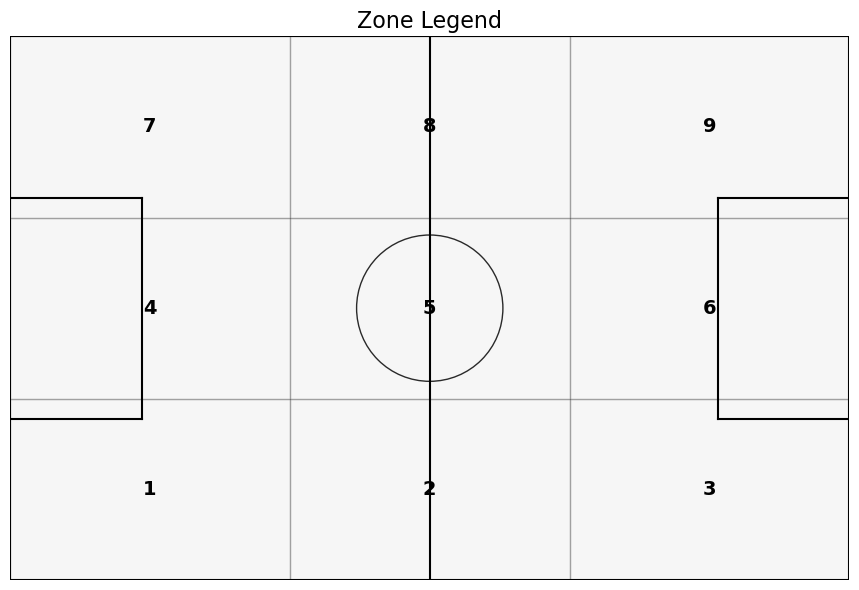

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Define edges matching your pitch grid
x_edges = np.linspace(-52.5, 52.5, 4)
y_edges = np.linspace(-34, 34, 4)

fig, ax = plt.subplots(figsize=(10, 6))

# Draw pitch outline
draw_pitch(ax)

zone_idx = 1

# Draw zone rectangles and labels
for y_bin in range(3):
    for x_bin in range(3):
        x_left = x_edges[x_bin]
        x_right = x_edges[x_bin + 1]
        y_bottom = y_edges[y_bin]
        y_top = y_edges[y_bin + 1]

        width = x_right - x_left
        height = y_top - y_bottom

        rect = patches.Rectangle(
            (x_left, y_bottom),
            width,
            height,
            linewidth=1,
            edgecolor='black',
            facecolor='lightgrey',
            alpha=0.2
        )
        ax.add_patch(rect)

        # Label in center
        x_center = (x_left + x_right) / 2
        y_center = (y_bottom + y_top) / 2

        ax.text(
            x_center, y_center,
            str(zone_idx),
            ha='center',
            va='center',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

        zone_idx += 1

ax.set_title("Zone Legend", fontsize=16)
plt.tight_layout()
plt.show()

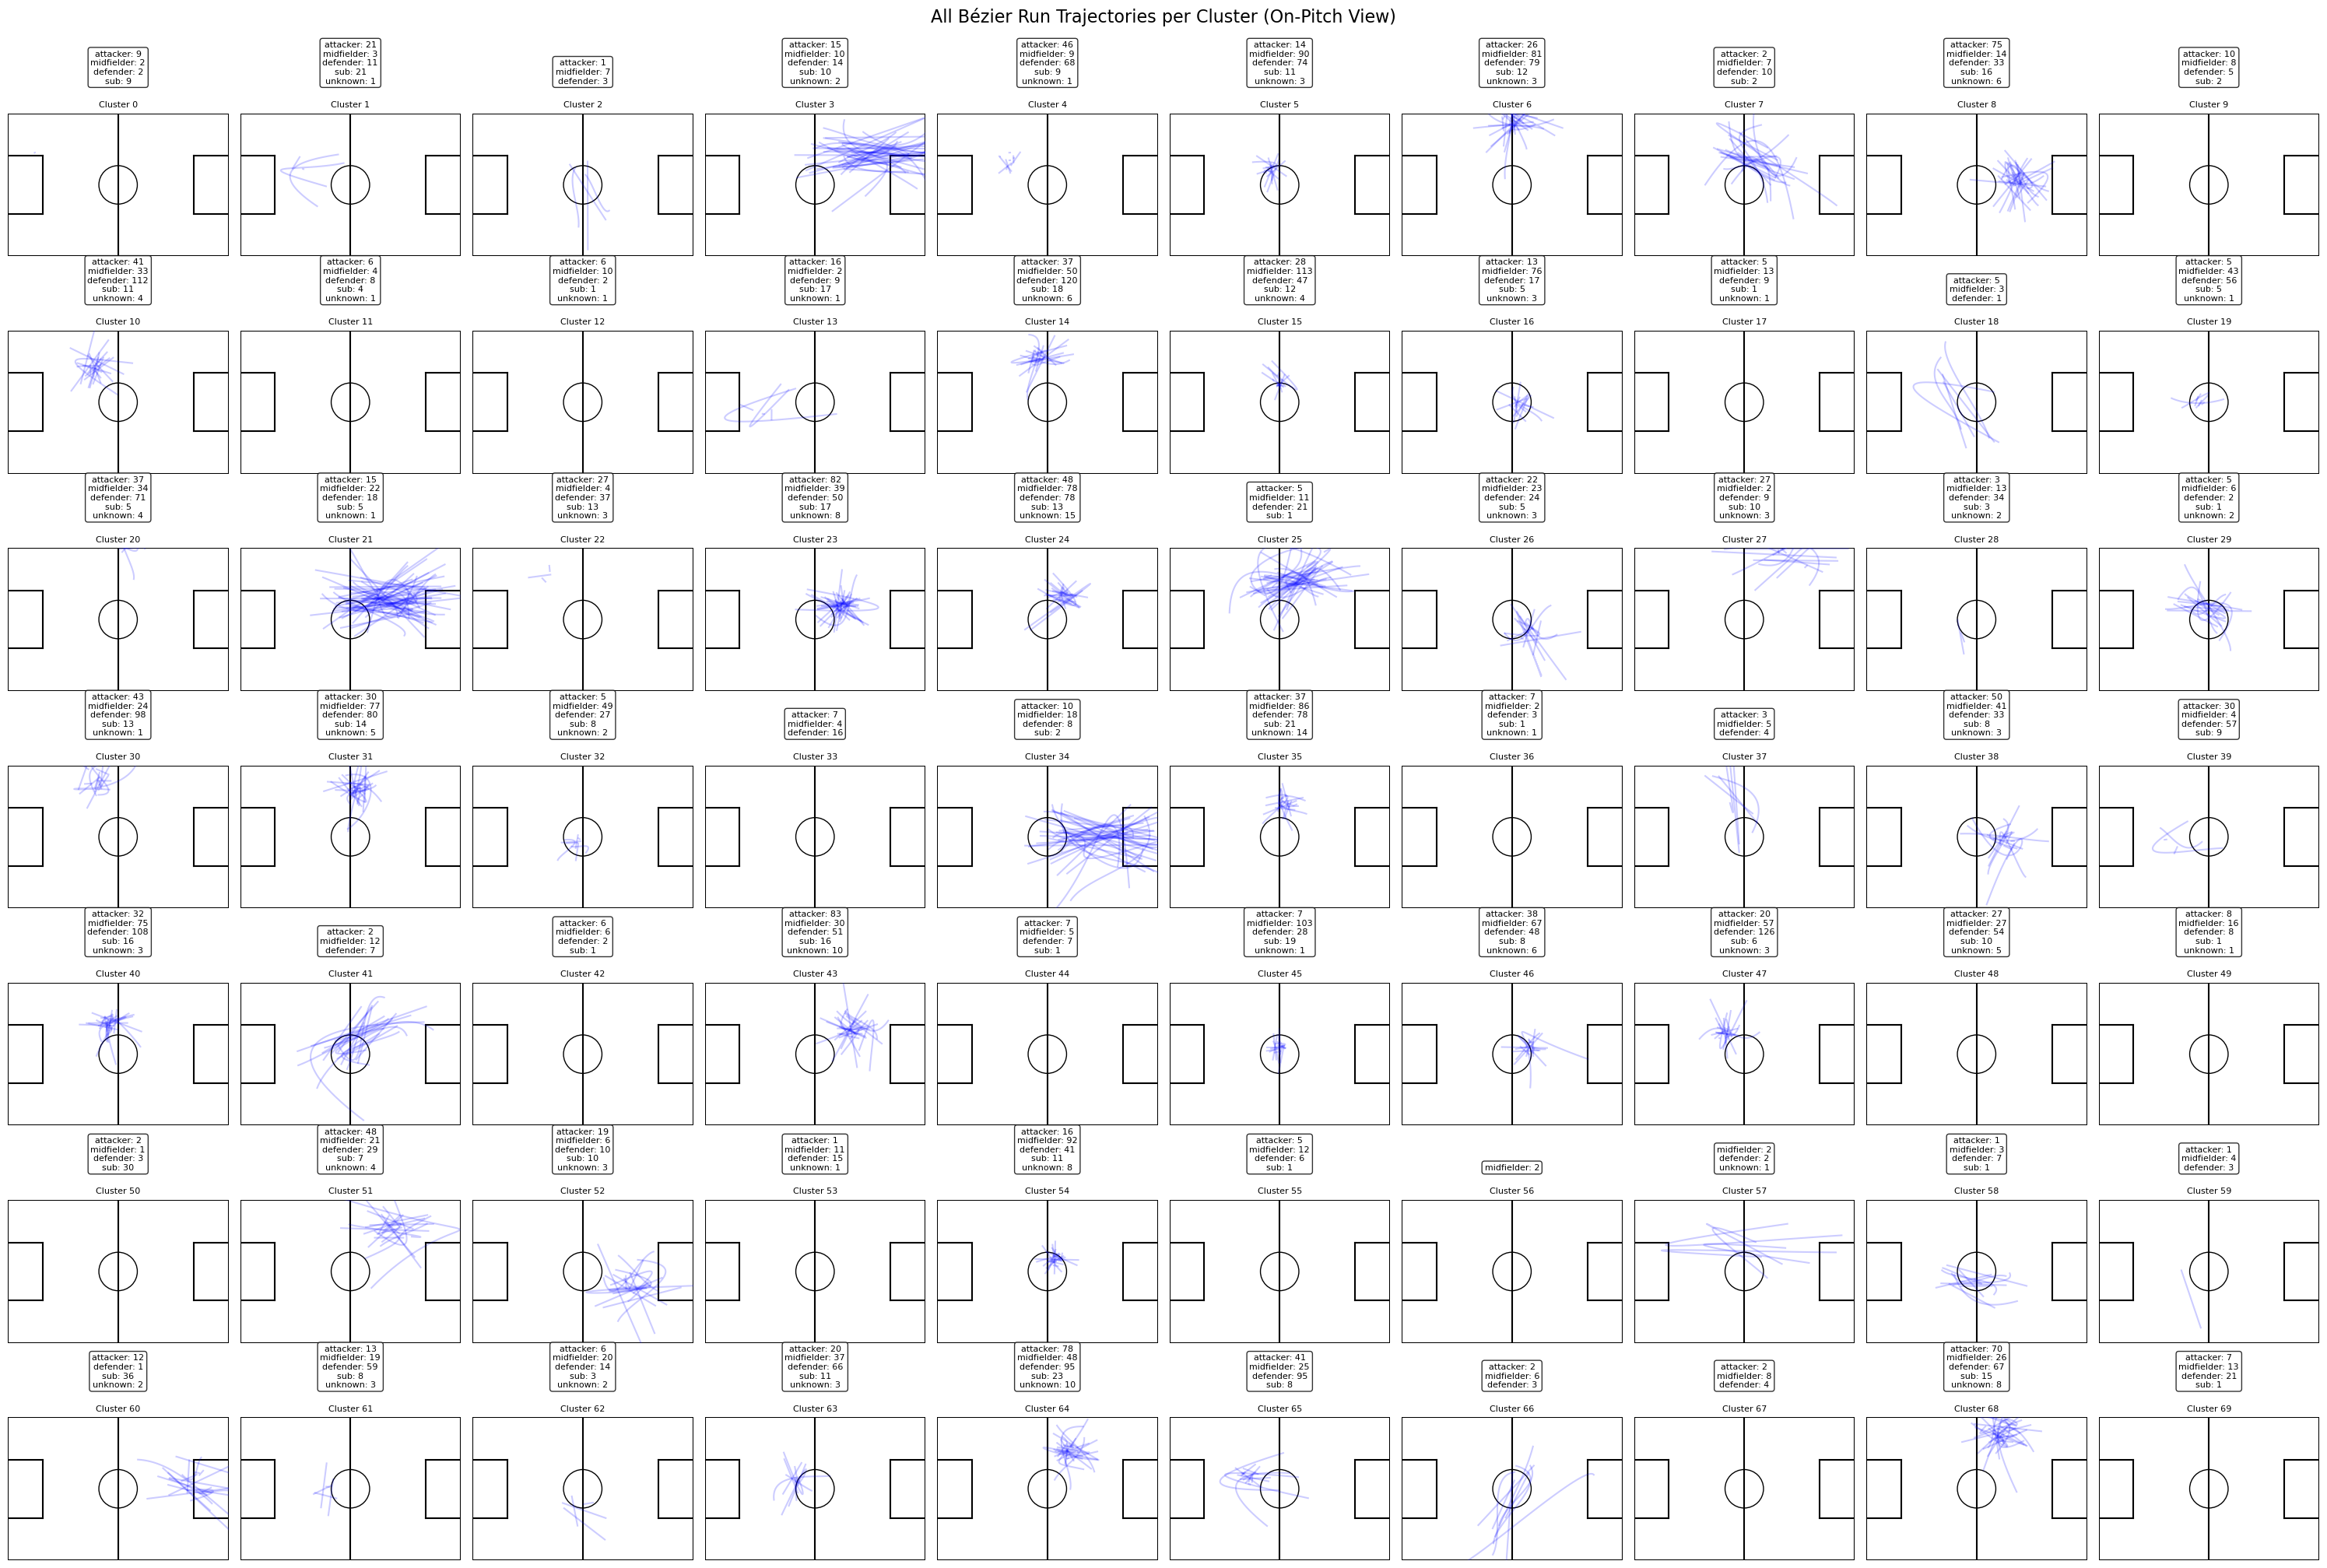

In [30]:
plot_all_cluster_trajectories_on_pitch(
    final_runs_df,
    assignments_zones,
    cluster_control_points,
    bucket_pivot=bucket_pivot,
    num_control_points=4,
    max_runs_per_cluster=200,
    plot_absolute_positions=False,
    start_zones=None,
    end_zones=None,  # You can specify zones like [1, 2, 3] if you want to filter
    phases_of_play=None,
    positions=None,
    use_absolute_zones=False, # True or False are options
    start_zones_absolute=None,
    end_zones_absolute=None,
    run_angle_range=None,  # Example: filter for runs with angles between 0 and 180 degrees
    run_forward=True,
    run_length_range = None,  # Example: filter for runs with length between 0 and 100 meters
    mean_speed_range = None,  # Example: filter for runs with mean speed between 0 and 8 m/s
    max_speed_range = None,
    tactical_overlap=None,
    tactical_underlap=None,
    tactical_diagonal=None     
)

# RL: OBV

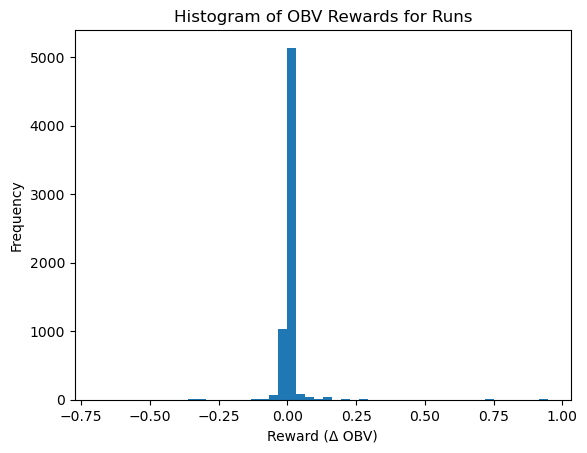

   run_id  reward
0       0     0.0
1       1     0.0
2       2     0.0
3       3     0.0
4       4     0.0


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_75067/563892256.py:144: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reward_assignments_df["reward"].fillna(0.0, inplace=True)


In [31]:
# ------------------------------------------------------------------------
# STEP 1 — ensure seconds_period in final_runs_df
# ------------------------------------------------------------------------

def ensure_seconds_period(final_runs_df, frames_df):
    """
    Ensures seconds_period is present in final_runs_df.
    """
    frames_df["seconds_period"] = 45*60 - frames_df["gameClock"]

    if "seconds_period" not in final_runs_df.columns:
        final_runs_df = final_runs_df.merge(
            frames_df[["match_id", "period", "frameIdx", "seconds_period"]],
            on=["match_id", "period", "frameIdx"],
            how="left",
        )
    return final_runs_df

final_runs_df = ensure_seconds_period(final_runs_df, frames_df)

# ------------------------------------------------------------------------
# STEP 2 — extract OBV value
# ------------------------------------------------------------------------

def extract_obv_value(event_row, obv_column="obv_total_net"):
    """
    Extract OBV value directly from top-level column.
    """
    val = event_row.get(obv_column, 0.0)
    if val is None or pd.isna(val):
        return 0.0
    return val

# ------------------------------------------------------------------------
# STEP 3 — compute OBV delta for a single run
# ------------------------------------------------------------------------

def compute_obv_delta_for_run(run_df, events_df, obv_column="obv_total_net", lookahead_seconds=30.0):
    """
    Compute OBV reward for a single run:
        OBV(after the run) - OBV(before the run)
    """
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]

    run_start_time = run_df["seconds_period"].min()
    run_end_time = run_df["seconds_period"].max()

    # Filter events for same period
    events_period = events_df[events_df["period"] == period]

    # Last event before the run
    before_events = events_period[
        events_period["seconds_period"] < run_start_time
    ]

    if not before_events.empty:
        last_before = before_events.iloc[-1]
        obv_before = extract_obv_value(last_before, obv_column)
    else:
        obv_before = 0.0

    # First event after the run
    after_events = events_period[
        (events_period["seconds_period"] > run_end_time) &
        (events_period["seconds_period"] <= run_end_time + lookahead_seconds)
    ]

    if not after_events.empty:
        first_after = after_events.iloc[0]
        obv_after = extract_obv_value(first_after, obv_column)
    else:
        obv_after = obv_before

    delta_obv = obv_after - obv_before
    return delta_obv

# ------------------------------------------------------------------------
# STEP 4 — assign OBV rewards to all runs
# ------------------------------------------------------------------------

def assign_obv_rewards_to_runs(final_runs_df, events_dfs_by_match, lookahead_seconds=30.0):
    """
    Compute OBV delta rewards for all runs.
    
    Returns:
        DataFrame with columns: run_id, reward
    """
    run_rewards = []

    grouped_runs = final_runs_df.groupby("run_id")

    for run_id, run_df in grouped_runs:
        match_id = run_df["match_id"].iloc[0]

        # Clean the match ID like your test code does:
        match_id_clean = match_id.replace(".json", "")

        events_df = events_dfs_by_match.get(match_id_clean)

        if events_df is None:
            reward = 0.0
        else:
            reward = compute_obv_delta_for_run(
                run_df,
                events_df,
                obv_column="obv_total_net",
                lookahead_seconds=lookahead_seconds,
            )

        run_rewards.append({
            "run_id": run_id,
            "reward": reward
        })

    return pd.DataFrame(run_rewards)

# ------------------------------------------------------------------------
# STEP 5 — run the pipeline
# ------------------------------------------------------------------------

run_rewards_df = assign_obv_rewards_to_runs(
    final_runs_df,
    events_dfs_by_match,
    lookahead_seconds=30.0
)

# OPTIONAL: show histogram
import matplotlib.pyplot as plt

plt.hist(run_rewards_df["reward"], bins=50)
plt.title("Histogram of OBV Rewards for Runs")
plt.xlabel("Reward (Δ OBV)")
plt.ylabel("Frequency")
plt.show()

# Merge with assignments
reward_assignments_df = assignments_df.merge(
    run_rewards_df,
    on="run_id",
    how="left"
)

reward_assignments_df["reward"].fillna(0.0, inplace=True)

print(run_rewards_df.head())

In [32]:
# ------------------------------------------------------------
# STEP 6 — build run-centric features
# ------------------------------------------------------------

def compute_run_features(final_runs_df):
    """
    For each run_id, compute geometric features for pure run regression.
    """
    run_feature_rows = []
    
    grouped = final_runs_df.groupby("run_id")
    
    for run_id, run_df in grouped:
        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        
        # Get start & end locations
        x_start = run_df["x"].iloc[0]
        y_start = run_df["y"].iloc[0]
        x_end = run_df["x"].iloc[-1]
        y_end = run_df["y"].iloc[-1]
        
        dx = x_end - x_start
        dy = y_end - y_start
        length = np.hypot(dx, dy)
        
        # Angle in radians (0 = rightward, π/2 = upward)
        angle = np.arctan2(dy, dx)
        
        # Duration
        duration = run_df["seconds_period"].max() - run_df["seconds_period"].min()
        
        # Average speed
        avg_speed = run_df["speed"].mean()
        
        run_feature_rows.append({
            "run_id": run_id,
            "match_id": match_id,
            "period": period,
            "x_start": x_start,
            "y_start": y_start,
            "x_end": x_end,
            "y_end": y_end,
            "length": length,
            "angle": angle,
            "duration": duration,
            "avg_speed": avg_speed
        })
        
    return pd.DataFrame(run_feature_rows)

run_features_df = compute_run_features(final_runs_df)
print(run_features_df.head())

   run_id                match_id  period  x_start  y_start  x_end  y_end  \
0       0  tracking_g2292810.json       2   -21.45    -4.17 -29.21  -9.85   
1       1  tracking_g2292810.json       2   -21.83   -17.53 -21.83 -17.53   
2       2  tracking_g2292810.json       2     1.01   -13.29   1.01 -13.29   
3       3  tracking_g2292810.json       2   -39.56   -10.85 -39.56 -10.85   
4       4  tracking_g2292810.json       2   -25.06     5.98 -25.06   5.98   

     length     angle  duration  avg_speed  
0  9.616652 -2.509738      3.36       3.30  
1  0.000000  0.000000      0.00       4.08  
2  0.000000  0.000000      0.00       3.20  
3  0.000000  0.000000      0.00       3.72  
4  0.000000  0.000000      0.00       4.72  


In [33]:
# ------------------------------------------------------------
# STEP 7 — build state vectors for contextual bandit
# ------------------------------------------------------------

def create_state_vectors(final_runs_df, players_df, frames_df):
    """
    For each run, extract the full player and ball context
    at the first frame of the run.
    """
    state_rows = []
    
    for run_id, run_df in final_runs_df.groupby("run_id"):
        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        start_frame = run_df["frameIdx"].min()

        # Player positions
        players_at_start = players_df[
            (players_df["match_id"] == match_id) &
            (players_df["period"] == period) &
            (players_df["frameIdx"] == start_frame)
        ]

        player_coords = []
        for _, p in players_at_start.iterrows():
            player_coords.extend([p["x"], p["y"]])
        
        # Check how many players we found
        if len(player_coords) < 22 * 2:
            # Skip this run
            continue
        
        # Ball position
        ball_at_start = frames_df[
            (frames_df["match_id"] == match_id) &
            (frames_df["period"] == period) &
            (frames_df["frameIdx"] == start_frame)
        ]
        
        if ball_at_start.empty:
            continue
        
        ball_x = ball_at_start["ball_x"].iloc[0]
        ball_y = ball_at_start["ball_y"].iloc[0]
        
        # Build state vector
        state_vector = np.array(player_coords + [ball_x, ball_y])
        
        state_rows.append({
            "run_id": run_id,
            "state_vector": state_vector
        })
    
    return pd.DataFrame(state_rows)

states_df = create_state_vectors(final_runs_df, players_df, frames_df)
print(states_df.head())

   run_id                                       state_vector
0       0  [-21.45, -4.17, 4.14, -7.99, -22.34, 9.82, -11...
1       1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...
2       2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...
3       3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...
4       4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...


In [34]:
# ------------------------------------------------------------
# STEP 7 — build state vectors for contextual bandit
# ------------------------------------------------------------

def create_state_vectors(final_runs_df, players_df, frames_df):
    """
    For each run, extract the full player and ball context
    at the first frame of the run.
    """
    state_rows = []
    
    for run_id, run_df in final_runs_df.groupby("run_id"):
        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        start_frame = run_df["frameIdx"].min()

        # Player positions
        players_at_start = players_df[
            (players_df["match_id"] == match_id) &
            (players_df["period"] == period) &
            (players_df["frameIdx"] == start_frame)
        ]

        player_coords = []
        for _, p in players_at_start.iterrows():
            player_coords.extend([p["x"], p["y"]])
        
        # Check how many players we found
        if len(player_coords) < 22 * 2:
            # Skip this run
            continue
        
        # Ball position
        ball_at_start = frames_df[
            (frames_df["match_id"] == match_id) &
            (frames_df["period"] == period) &
            (frames_df["frameIdx"] == start_frame)
        ]
        
        if ball_at_start.empty:
            continue
        
        ball_x = ball_at_start["ball_x"].iloc[0]
        ball_y = ball_at_start["ball_y"].iloc[0]
        
        # Build state vector
        state_vector = np.array(player_coords + [ball_x, ball_y])
        
        state_rows.append({
            "run_id": run_id,
            "state_vector": state_vector
        })
    
    return pd.DataFrame(state_rows)

states_df = create_state_vectors(final_runs_df, players_df, frames_df)
print(states_df.head())

   run_id                                       state_vector
0       0  [-21.45, -4.17, 4.14, -7.99, -22.34, 9.82, -11...
1       1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...
2       2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...
3       3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...
4       4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...


In [35]:
# ------------------------------------------------------------
# STEP 8 — Merge actions and rewards
# ------------------------------------------------------------

# actions_df maps run_id → cluster index
actions_df = assignments_df[["run_id", "assigned_cluster"]].rename(columns={
    "assigned_cluster": "action"
})

# Merge run_id → action
bandit_data = states_df.merge(
    actions_df,
    on="run_id",
    how="inner"
)

# Merge run_id → reward
bandit_data = bandit_data.merge(
    run_rewards_df,
    on="run_id",
    how="inner"
)

print(bandit_data.head())

# One-hot encode actions
action_onehot = pd.get_dummies(bandit_data["action"], prefix="cluster")
bandit_data_onehot = pd.concat([bandit_data, action_onehot], axis=1)

print(bandit_data_onehot.head())

   run_id                                       state_vector  action  reward
0       0  [-21.45, -4.17, 4.14, -7.99, -22.34, 9.82, -11...      23     0.0
1       1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      31     0.0
2       2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      10     0.0
3       3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...      43     0.0
4       4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      23     0.0
   run_id                                       state_vector  action  reward  \
0       0  [-21.45, -4.17, 4.14, -7.99, -22.34, 9.82, -11...      23     0.0   
1       1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      31     0.0   
2       2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      10     0.0   
3       3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...      43     0.0   
4       4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      23     0.0   

   cluster_0  cluster_1  cluster_2  cluster_3  cluster_4 

In [36]:
# Features for pure run regression
X_run = run_features_df.drop(columns=["run_id", "match_id", "period"]).values
y_run = run_rewards_df.merge(
    run_features_df[["run_id"]],
    on="run_id",
    how="inner"
)["reward"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_run, y_run, test_size=0.2, random_state=42
)

model_run = LGBMRegressor(n_estimators=100)
model_run.fit(X_train, y_train)

y_pred = model_run.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"[OPTION 1] Run-Centric Regression MSE: {mse:.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 5173, number of used features: 8
[LightGBM] [Info] Start training from score 0.001623
[OPTION 1] Run-Centric Regression MSE: 0.002645


In [37]:
# Prepare combined feature vectors
X_bandit = np.stack(
    bandit_data_onehot["state_vector"].values
)

# Add action one-hot
X_bandit = np.concatenate([
    X_bandit,
    bandit_data_onehot.filter(like="cluster_").values
], axis=1)

y_bandit = bandit_data_onehot["reward"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_bandit, y_bandit, test_size=0.2, random_state=42
)

model_bandit = LGBMRegressor(n_estimators=100)
model_bandit.fit(X_train, y_train)

y_pred = model_bandit.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"[OPTION 2] Contextual Bandit MSE: {mse:.6f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11784
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 97
[LightGBM] [Info] Start training from score 0.001793
[OPTION 2] Contextual Bandit MSE: 0.000989


In [74]:


class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_space_size, hidden_size=256):
        super().__init__()
        input_dim = state_dim + action_space_size
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, state_action_batch):
        return self.net(state_action_batch).squeeze(-1)
    
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_space_size, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_space_size)
        )
    
    def forward(self, state_batch):
        return self.net(state_batch)

class FootballOffBallRL(BaseEstimator):
    """
    RL pipeline for off-ball runs in football.
    
    This class:
    - stores state/action/reward/next-state data
    - fits an RL model (e.g. fitted Q iteration)
    - ranks players by long-term run value
    
    Customisable:
    - State feature extraction
    - Reward functions
    - Learning algorithms
    """

    def __init__(
        self,
        method="lightgbm",        # "lightgbm" or "dqn"
        gamma=0.9,
        n_iters=10,
        action_space_size=70,
        regressor=None,           # Used only for LightGBM
        state_fn=None,
        reward_fn=None,
        # DQN specific:
        state_dim=None,
        hidden_size=256,
        batch_size=128,
        learning_rate=1e-3,
        device="cpu",
        target_update_freq=1000,  # How often to update target network
    ):
        self.method = method
        self.gamma = gamma
        self.n_iters = n_iters
        self.action_space_size = action_space_size
        self.state_fn = state_fn
        self.reward_fn = reward_fn
        self.target_update_freq = target_update_freq

        if method == "lightgbm":
            self.regressor = regressor if regressor is not None else LGBMRegressor()
        elif method == "dqn":
            assert state_dim is not None, "state_dim required for DQN"
            self.q_network = QNetwork(
                state_dim=state_dim,
                action_space_size=action_space_size,
                hidden_size=hidden_size
            ).to(device)

            # NEW: Target network
            self.target_q_network = QNetwork(
                state_dim=state_dim,
                action_space_size=action_space_size,
                hidden_size=hidden_size
            ).to(device)

            # Initially identical
            self.target_q_network.load_state_dict(self.q_network.state_dict())
            self.target_q_network.eval()

            self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
            self.loss_fn = nn.MSELoss()
            self.device = device
            self.batch_size = batch_size
            self.target_update_freq = target_update_freq or 1000
        else:
            raise ValueError("method must be either 'lightgbm' or 'dqn'")
        
    def update_target_network(self):
        """
        Copies weights from the online network to the target network.
        """
        self.target_q_network.load_state_dict(self.q_network.state_dict())
                
    def prepare_data(self, runs_df, players_df, frames_df, assignments_df, events_dfs_by_match):
        """
        Constructs RL dataset:
            run_id → (state, action, reward, next_state, player_id)
        """
        print("Preparing RL dataset...")
        data_rows = []
        
        grouped = runs_df.groupby("run_id")
        
        for run_id, run_df in tqdm(grouped, total=len(grouped)):
            match_id = run_df["match_id"].iloc[0]
            period = run_df["period"].iloc[0]
            player_id = run_df["playerId"].iloc[0]
            start_frame = run_df["frameIdx"].min()
            end_frame = run_df["frameIdx"].max()

            # ---------------------------------------------
            # 1. State at start
            # ---------------------------------------------
            start_state_row = self._extract_frame_state(
                match_id, period, start_frame, players_df, frames_df
            )
            if start_state_row is None:
                continue

            state_vector = self.state_fn(start_state_row)
            
            # ---------------------------------------------
            # 2. Next State after run
            # ---------------------------------------------
            end_state_row = self._extract_frame_state(
                match_id, period, end_frame, players_df, frames_df
            )
            if end_state_row is None:
                continue

            next_state_vector = self.state_fn(end_state_row)

            # ---------------------------------------------
            # 3. Action
            # ---------------------------------------------
            assigned_cluster = assignments_df.loc[
                assignments_df["run_id"] == run_id, "assigned_cluster"
            ]
            if assigned_cluster.empty:
                continue
            action = int(assigned_cluster.values[0])
            
            # ---------------------------------------------
            # 4. Reward
            # ---------------------------------------------
            # if self.reward_fn is not None:
            #     # Extract events for this match
            #     events_df = events_dfs_by_match.get(match_id, None)
            #     if events_df is None:
            #         reward = 0.0
            #     else:
            #         reward = self.reward_fn(run_df, events_df)
            #         if reward is None:
            #             reward = 0.0
            # else:
            #     reward = 0.0
            if self.reward_fn is not None:
                match_key = match_id.replace(".json", "")
                events_df = events_dfs_by_match.get(match_key, None)
                if events_df is None:
                    print(f"[WARN] No events found for match_id: {match_key}")
                reward = self.reward_fn(run_df, events_df) if events_df is not None else 0.0
            else:
                reward = 0.0
            
            data_rows.append({
                "run_id": run_id,
                "state": state_vector,
                "action": action,
                "reward": reward,
                "next_state": next_state_vector,
                "playerId": player_id
            })

        self.rl_data_ = pd.DataFrame(data_rows)
        print(f"Prepared {len(self.rl_data_)} RL transitions.")
        return self.rl_data_
    
    def _extract_frame_state(self, match_id, period, frame_idx, players_df, frames_df):
        """
        Helper to extract a single frame's state.
        """
        players_at_frame = players_df[
            (players_df["match_id"] == match_id) &
            (players_df["period"] == period) &
            (players_df["frameIdx"] == frame_idx)
        ]
        if len(players_at_frame) < 22:
            return None
        
        player_coords = []
        for _, p in players_at_frame.iterrows():
            player_coords.extend([p["x"], p["y"]])

        ball_at_frame = frames_df[
            (frames_df["match_id"] == match_id) &
            (frames_df["period"] == period) &
            (frames_df["frameIdx"] == frame_idx)
        ]
        if ball_at_frame.empty:
            return None
        
        ball_x = ball_at_frame["ball_x"].iloc[0]
        ball_y = ball_at_frame["ball_y"].iloc[0]

        return {
            "player_coords": np.array(player_coords),
            "ball_coords": np.array([ball_x, ball_y])
        }
    
    def fit(self):
        if self.method == "lightgbm":
            self._fit_lightgbm()
        elif self.method == "dqn":
            self._fit_dqn()
        else:
            raise ValueError("Invalid method")
  
    # --------------------
    # LightGBM FQI
    # --------------------

    def _fit_lightgbm(self):
        df = self.rl_data_
        X = self._build_features(df["state"], df["action"])
        y = df["reward"].values.copy()

        for it in range(self.n_iters):
            self.regressor.fit(X, y)
            next_Q_vals = self.predict_next_state_values(df["next_state"])
            y = df["reward"].values + self.gamma * next_Q_vals
            print(f"[LightGBM] Iteration {it+1}/{self.n_iters} done.")
        
        self.fitted_ = True

       # --------------------
    # DQN
    # --------------------

    def _fit_dqn(self):
        df = self.rl_data_

        states = np.stack(df["state"].values)
        actions = df["action"].values
        rewards = df["reward"].values
        next_states = np.stack(df["next_state"].values)

        dataset_size = len(df)

        for epoch in range(self.n_iters):
            perm = np.random.permutation(dataset_size)
            for start in range(0, dataset_size, self.batch_size):
                idx = perm[start:start+self.batch_size]
                
                s_batch = torch.tensor(states[idx], dtype=torch.float32, device=self.device)
                a_batch = torch.tensor(actions[idx], dtype=torch.int64, device=self.device)
                r_batch = torch.tensor(rewards[idx], dtype=torch.float32, device=self.device)
                s2_batch = torch.tensor(next_states[idx], dtype=torch.float32, device=self.device)

                # Create (s,a)
                onehot_a = torch.eye(self.action_space_size, device=self.device)[a_batch]
                sa_batch = torch.cat([s_batch, onehot_a], dim=1)

                # Compute target:
                with torch.no_grad():
                    target_q_vals = self.target_q_network(s2_batch)   # shape (batch, n_actions)
                    max_q_next = target_q_vals.max(dim=1).values

                    y_batch = r_batch + self.gamma * max_q_next

                # Compute Q(s,a) for taken actions:
                online_q_vals = self.q_network(s_batch)
                q_pred = online_q_vals.gather(1, a_batch.unsqueeze(1)).squeeze(1)

                # Loss and update
                loss = self.loss_fn(q_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            print(f"[DQN] Epoch {epoch+1}/{self.n_iters} done.")
        
        self.fitted_ = True
    
    # --------------------
    # Q prediction
    # --------------------

    def predict_next_state_values(self, next_states):
        if self.method == "lightgbm":
            all_qs = []
            for a in range(self.action_space_size):
                feats = self._build_features(next_states, [a] * len(next_states))
                qs = self.regressor.predict(feats)
                all_qs.append(qs)
            all_qs = np.stack(all_qs, axis=1)
            return np.max(all_qs, axis=1)
        elif self.method == "dqn":
            next_states_tensor = torch.tensor(np.stack(next_states), dtype=torch.float32, device=self.device)
            all_qs = []
            next_qs = self.q_network(next_states_tensor)   # (batch, n_actions)
            return next_qs.max(dim=1).values.cpu().numpy()
    

    def Q(self, state, action):
        if self.method == "lightgbm":
            X = self._build_features([state], [action])
            return self.regressor.predict(X)[0]
        elif self.method == "dqn":
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)   # shape (1, n_actions)
                return q_values[0, action].item()
    
    def _build_features(self, states, actions):
        """
        Build combined feature vector for regressor:
            state + one-hot(action)
        """
        states_arr = np.stack(states)
        actions_onehot = np.eye(self.action_space_size)[actions]
        return np.concatenate([states_arr, actions_onehot], axis=1)
    
    def rank_players(self):
        """
        Aggregate Q-values for all players.
        """
        df = self.rl_data_.copy()
        df["q_value"] = df.apply(
            lambda row: self.Q(row["state"], row["action"]),
            axis=1
        )
        player_values = df.groupby("playerId")["q_value"].mean()
        return player_values.sort_values(ascending=False)
    
    def plot_player_q_distribution(self, player_id=None, bins=50):
        """
        Plots the histogram of Q-values for:
            - one specific player (if player_id given), OR
            - all players combined
        
        Parameters
        ----------
        player_id : str or None
            Player UUID to plot. If None, plots for all players combined.
        bins : int
            Number of histogram bins.
        """
        df = self.rl_data_.copy()

        # Compute Q-values if not yet stored
        if "q_value" not in df.columns:
            df["q_value"] = df.apply(
                lambda row: self.Q(row["state"], row["action"]),
                axis=1
            )

        if player_id is not None:
            df = df[df["playerId"] == player_id]
            if df.empty:
                print(f"No data found for playerId: {player_id}")
                return

            title = f"Q-value distribution for player {player_id}"
        else:
            title = "Q-value distribution across all players"

        plt.figure(figsize=(8, 5))
        sns.histplot(df["q_value"], bins=bins, kde=True, color="steelblue")
        plt.title(title)
        plt.xlabel("Q-value")
        plt.ylabel("Frequency")
        plt.show()

# Simple Example code: 

In [75]:
def simple_state_fn(state_row):
    """
    Converts state_row into a flat vector:
    [player_x1, player_y1, ..., player_x22, player_y22, ball_x, ball_y]
    """
    player_coords = state_row["player_coords"]
    ball_coords = state_row["ball_coords"]
    return np.concatenate([player_coords, ball_coords])

def obv_reward_fn(run_df, events_df, lookahead_seconds=30.0):
    """
    Computes OBV delta reward for a run.
    """
    if events_df is None:
        return 0.0
    
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]

    run_start_time = run_df["seconds_period"].min()
    run_end_time = run_df["seconds_period"].max()

    events_period = events_df[events_df["period"] == period]

    # Last event before run
    before_events = events_period[
        events_period["seconds_period"] < run_start_time
    ]
    if not before_events.empty:
        obv_before = before_events.iloc[-1]["obv_total_net"]
    else:
        obv_before = 0.0

    # First event after run
    after_events = events_period[
        (events_period["seconds_period"] > run_end_time) &
        (events_period["seconds_period"] <= run_end_time + lookahead_seconds)
    ]
    if not after_events.empty:
        obv_after = after_events.iloc[0]["obv_total_net"]
    else:
        obv_after = obv_before
    
    delta_obv = obv_after - obv_before

    if delta_obv is None or pd.isna(delta_obv):
        delta_obv = 0.0
    
    return float(delta_obv)

    #return obv_after - obv_before



In [76]:

model_lightgbm = FootballOffBallRL(
    method="lightgbm",
    gamma=0.9,
    n_iters=5,
    action_space_size=70,
    state_fn=simple_state_fn,
    reward_fn=obv_reward_fn
)

model_dqn = FootballOffBallRL(
    method="dqn",
    gamma=0.9,
    n_iters=5,
    action_space_size=70,
    state_dim=46,         # your state vector length
    hidden_size=256,
    batch_size=64,
    learning_rate=1e-3,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),        # or "cpu"
    state_fn=simple_state_fn,
    reward_fn=obv_reward_fn
)



In [77]:
rl_data_df_lightgbm = model_lightgbm.prepare_data(
    runs_df=final_runs_df,
    players_df=players_df,
    frames_df=frames_df,
    assignments_df=assignments_df,
    events_dfs_by_match=events_dfs_by_match
)

rl_data_df_dqn = model_dqn.prepare_data(
    runs_df=final_runs_df,
    players_df=players_df,
    frames_df=frames_df,
    assignments_df=assignments_df,
    events_dfs_by_match=events_dfs_by_match
)

Preparing RL dataset...


100%|██████████| 6467/6467 [00:31<00:00, 202.21it/s]


Prepared 6320 RL transitions.
Preparing RL dataset...


100%|██████████| 6467/6467 [00:31<00:00, 205.87it/s]

Prepared 6320 RL transitions.


Rows in rl_data_df: LIGHTGBM 6320
Number of NaN rewards: LIGHTGBM 0

Reward distribution summary: LIGHTGBM
count    6320.000000
mean        0.001161
std         0.033577
min        -0.502250
25%         0.000000
50%         0.000000
75%         0.000000
max         0.948417
Name: reward, dtype: float64


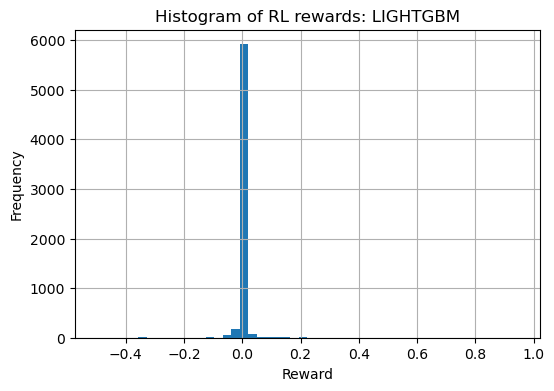

First few rows of RL data: LIGHTGBM
   run_id                                              state  action  reward  \
0       0  [-21.45, -4.17, 4.14, -7.99, -22.34, 9.82, -11...      23     0.0   
1       1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      31     0.0   
2       2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      10     0.0   
3       3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...      43     0.0   
4       4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      23     0.0   

                                          next_state  \
0  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   
1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   
2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   
3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...   
4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   

                               playerId  
0  061f0c23-6ff3-4012-aa57-b67f216dd873  
1  180caca0-e3e6-4e65-9db1-d2c61cd751e6  
2  281b8199-4222-423

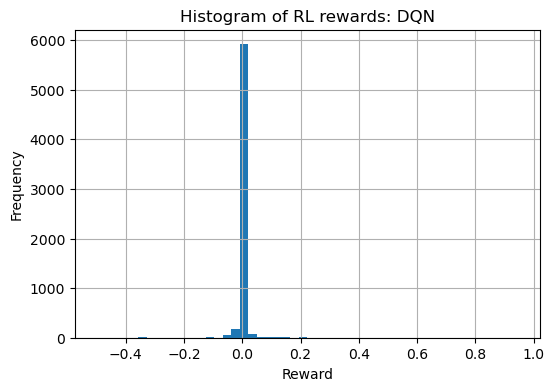

First few rows of RL data: DQN
   run_id                                              state  action  reward  \
0       0  [-21.45, -4.17, 4.14, -7.99, -22.34, 9.82, -11...      23     0.0   
1       1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      31     0.0   
2       2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      10     0.0   
3       3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...      43     0.0   
4       4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...      23     0.0   

                                          next_state  \
0  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   
1  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   
2  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   
3  [-43.12, -2.26, -2.29, 1.38, -39.56, -10.85, -...   
4  [-29.21, -9.85, 1.01, -13.29, -25.06, 5.98, -1...   

                               playerId  
0  061f0c23-6ff3-4012-aa57-b67f216dd873  
1  180caca0-e3e6-4e65-9db1-d2c61cd751e6  
2  281b8199-4222-423e-a0b

In [78]:


print(f"Rows in rl_data_df: LIGHTGBM {len(rl_data_df_lightgbm)}")
missing_rewards_lightgbm = rl_data_df_lightgbm["reward"].isna().sum()
print(f"Number of NaN rewards: LIGHTGBM {missing_rewards_lightgbm}")

# Describe the distribution (ignoring NaNs)
reward_stats_lightgbm = rl_data_df_lightgbm["reward"].dropna().describe()
print("\nReward distribution summary: LIGHTGBM")
print(reward_stats_lightgbm)

plt.figure(figsize=(6,4))
rl_data_df_lightgbm["reward"].dropna().hist(bins=50)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Histogram of RL rewards: LIGHTGBM")
plt.show()

print("First few rows of RL data: LIGHTGBM")
print(rl_data_df_lightgbm.head())

print("Reward summary: LIGHTGBM\n", rl_data_df_lightgbm["reward"].describe())
print("Actions distribution: LIGHTGBM\n", rl_data_df_lightgbm["action"].value_counts())
print("Players in data: LIGHTGBM\n", rl_data_df_lightgbm["playerId"].nunique())

# DQN: 

print(f"Rows in rl_data_df: DQN {len(rl_data_df_dqn)}")
missing_rewards_dqn = rl_data_df_dqn["reward"].isna().sum()
print(f"Number of NaN rewards: DQN {missing_rewards_dqn}")

# Describe the distribution (ignoring NaNs)
reward_stats_dqn = rl_data_df_dqn["reward"].dropna().describe()
print("\nReward distribution summary: DQN")
print(reward_stats_dqn)

plt.figure(figsize=(6,4))
rl_data_df_dqn["reward"].dropna().hist(bins=50)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Histogram of RL rewards: DQN")
plt.show()

print("First few rows of RL data: DQN")
print(rl_data_df_dqn.head())

print("Reward summary: DQN\n", rl_data_df_dqn["reward"].describe())
print("Actions distribution: DQN\n", rl_data_df_dqn["action"].value_counts())
print("Players in data: DQN\n", rl_data_df_dqn["playerId"].nunique())

Reward summary:
 count    6697.000000
mean        0.001091
std         0.033285
min        -0.333202
25%         0.000000
50%         0.000000
75%         0.000000
max         0.928933
Name: reward, dtype: float64
Actions distribution:
 action
33    269
31    246
16    235
47    209
65    206
     ... 
36     10
64      7
38      6
52      3
45      2
Name: count, Length: 70, dtype: int64
Players in data:
 471


In [79]:
# Fit Q(s,a)
model_lightgbm.fit()
model_dqn.fit()



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11798
[LightGBM] [Info] Number of data points in the train set: 6320, number of used features: 104
[LightGBM] [Info] Start training from score 0.001161
[LightGBM] Iteration 1/5 done.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11798
[LightGBM] [Info] Number of data points in the train set: 6320, number of used features: 104
[LightGBM] [Info] Start training from score 0.024839
[LightGBM] Iteration 2/5 done.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

In [80]:
player_ranks_lightgbm = model_lightgbm.rank_players()
print("DQN PLAYER RANKINGS:\n", player_ranks_lightgbm.head(20))

player_ranks_dqn = model_dqn.rank_players()
print("DQN PLAYER RANKINGS:\n", player_ranks_dqn.head(20))

DQN PLAYER RANKINGS:
 playerId
cb0ab46e-d24c-440a-9cd9-178a8f6b0c54    0.217143
7b3dba9c-e7f3-4ec1-9fff-8019260e4814    0.216504
55b7f84c-a394-44d9-89c5-50b5f3d16045    0.200562
a39d1782-b771-49d1-b858-b77d194f8194    0.190938
a1ef720e-a12e-4429-9432-a6c4efa4a937    0.183972
d80f7158-d77e-4156-ba1b-dabc62e8ebda    0.174708
ba38da76-d7b5-48b0-bcd3-3d5a40012383    0.166536
db337b47-0193-46a4-8caf-bb9063bf58e5    0.165048
36a74b19-a01e-4098-b56b-c9fea261f6fa    0.163697
4b335a41-f827-4888-84a2-b5cea97da2d3    0.145915
10881a3e-e18b-461a-a54f-bdb8f01ec089    0.141754
b49f679b-f2f4-4233-a9db-c7dd9e6e9aad    0.139113
d0235e3e-343b-4f33-8e1d-fe18747eba6c    0.138991
8388e4d9-10a2-4f7a-a9b8-82967c111a92    0.135108
1f588338-ee5b-4019-9b2e-edf737f03ec7    0.134821
3d02ab71-900d-4dda-bf07-d67be82140a0    0.128673
32d5f872-35a8-45fd-92e6-9c7bf5e7614e    0.127589
71180393-9351-4fc1-9988-5bb061a1ec24    0.121705
3adbe63a-c616-4e6d-b715-457b51903de8    0.120910
ee9a6088-31e5-4e04-a90f-ed80f0583c90  

In [81]:
state = rl_data_df_dqn.iloc[0]["state"]
qs_dqn = [model_dqn.Q(state, a) for a in range(model_dqn.action_space_size)]

best_action_dqn = np.argmax(qs_dqn)
print("Best action for this state:", best_action_dqn)
print("Q-value:", qs_dqn[best_action_dqn])

Best action for this state: 55
Q-value: 7.018307209014893


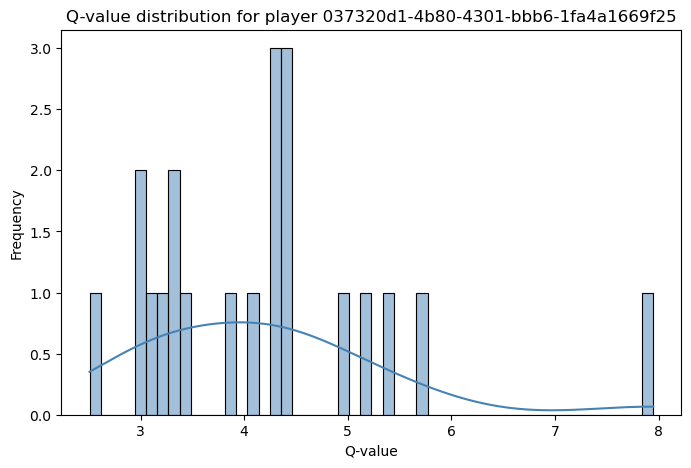

In [82]:
model_dqn.plot_player_q_distribution(player_id='037320d1-4b80-4301-bbb6-1fa4a1669f25')

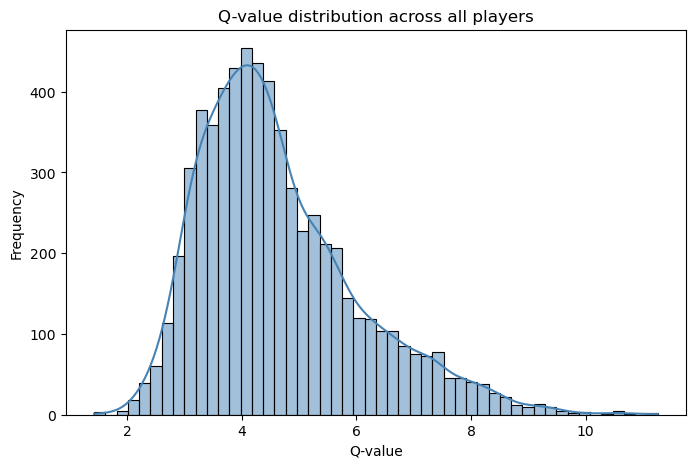

In [83]:
model_dqn.plot_player_q_distribution()

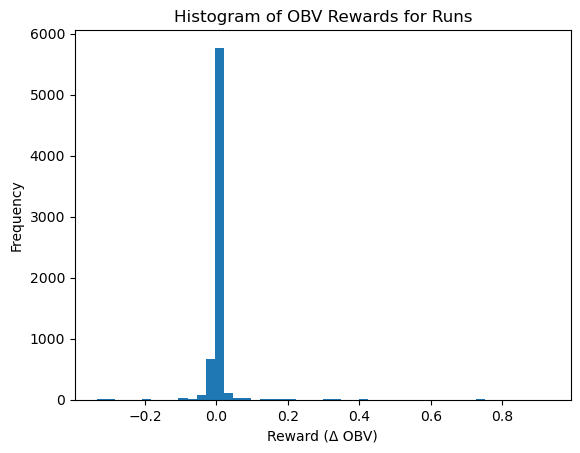

   run_id    reward
0       0  0.000000
1       1 -0.003285
2       2 -0.003285
3       3  0.006023
4       4  0.006023


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_62101/1514923243.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reward_assignments_df["reward"].fillna(0.0, inplace=True)


Index(['match_id', 'period', 'frameIdx', 'side', 'playerId', 'optaId',
       'number', 'x', 'y', 'z', 'speed', 'player_name', 'position',
       'team_role', 'run_id', 'y_mirror', 'x_mirror', 'in_possession',
       'phase_of_play', 'x_c', 'y_c', 'x_mirror_c', 'y_mirror_c',
       'seconds_period'],
      dtype='object')


Index(['match_id', 'period', 'frameIdx', 'side', 'playerId', 'optaId',
       'number', 'x', 'y', 'z', 'speed', 'player_name', 'position',
       'team_role', 'run_id', 'y_mirror', 'x_mirror', 'in_possession',
       'phase_of_play', 'x_c', 'y_c', 'x_mirror_c', 'y_mirror_c',
       'seconds_period'],
      dtype='object')


False
defend
False
defend
False
defend
False
defend
False
defend
True
attack
False
defend
False
defend
True
attack
False
defend
False
defend
True
attack
True
attack
True
attack
True
attack
True
attack
True
attack
True
attack
False
defend
False
defend
False
defend
False
defend
False
defend
False
defend
False
defend
False
defend
False
defend
True
attack
True
attack
True
attack
True
attack
False
defend
False
defend
True
attack
True
attack
False
defend
False
defend
True
attack
False
defend
True
attack
False
defend
False
defend
True
attack
False
defend
False
defend
False
defend
True
attack
True
attack
True
attack
False
defend
True
attack
False
defend
True
attack
True
attack
False
defend
False
defend
False
defend
False
defend
True
attack
False
defend
False
defend
True
attack
False
defend
True
attack
True
attack
True
attack
True
attack
False
defend
False
defend
False
defend
False
defend
False
defend
False
defend
False
defend
True
attack
True
attack
False
defend
False
defend
True
attack
False


   cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   cluster_6  cluster_7  cluster_8  cluster_9  ...  cluster_60  cluster_61  \
0          0          0          0          0  ...           1           0   
1          0          0          0          0  ...           0           0   
2          0          0          0          0  ...           0           0   
3          0          0          0          0  ...           0           0   
4          0          0          0          0  ...           0           0   

   cluster_62  cluster_63  cluster_64  cluster_65  cluster_66  cluster_67  \
0           0           0  

X shape: (6712, 118)
y shape: (6712,)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11826
[LightGBM] [Info] Number of data points in the train set: 5369, number of used features: 102
[LightGBM] [Info] Start training from score 0.003079
Test MSE: 0.000248
[ 0.00244033 -0.00210473  0.00308219  0.00790973  0.00771753 -0.00218922
  0.00183052  0.0005573  -0.00278404 -0.06811209]


Test MSE: 0.000248
Test RMSE: 0.015738
Test R²: 0.7874
Correlation between true and predicted rewards: 0.8896


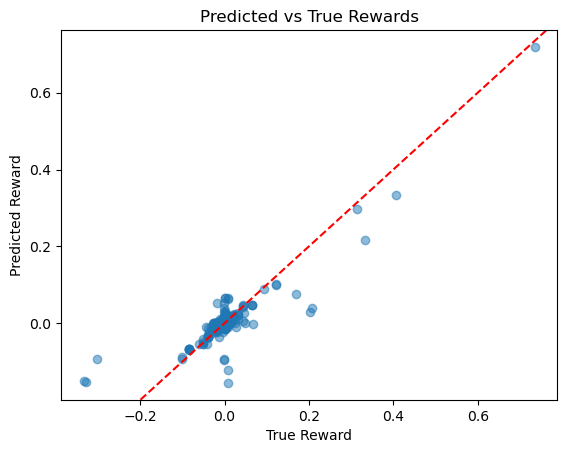

# Ideas on how to make overlapping runs more robust:

# Overlapping

In [ ]:
def extract_ball_carrier_df_fast(run_df, players_with_ball_df):
    """
    Fast version of extract_ball_carrier_df.
    """
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    frames = run_df["frameIdx"].unique()

    # Slice relevant frames for this run
    run_players = players_with_ball_df[
        (players_with_ball_df["match_id"] == match_id) &
        (players_with_ball_df["period"] == period) &
        (players_with_ball_df["frameIdx"].isin(frames))
    ]

    # Keep only teammates
    teammates = run_players[
        run_players["side"] == team_role
    ].copy()

    if teammates.empty:
        return None

    # Compute distance to ball
    teammates["dist_to_ball"] = np.linalg.norm(
        teammates[["x", "y"]].values - teammates[["ball_x", "ball_y"]].values,
        axis=1
    )

    # Find closest player in each frame
    idx_min_dist = teammates.groupby("frameIdx")["dist_to_ball"].idxmin()

    ball_carrier_df = teammates.loc[idx_min_dist]

    if ball_carrier_df.empty:
        return None
    else:
        return ball_carrier_df
    
# def is_overlapping_run(run_df, events_df, time_margin_seconds=1.0,
#                        max_angle_diff_deg=30, max_end_distance=5.0,
#                        min_pass_length=5.0,
#                        exclude_pass_types=None,
#                        require_regular_play=True):
#     """
#     Determines whether a run overlaps a pass in the event data.

#     Parameters
#     ----------
#     run_df : pd.DataFrame
#         Tracking run data (single run).
#     events_df : pd.DataFrame
#         StatsBomb events dataframe for the same match.
#     time_margin_seconds : float
#         Allowable margin before and after run times.
#     max_angle_diff_deg : float
#         Max angle difference between run vector and pass vector.
#     max_end_distance : float
#         Max allowed distance between run end point and pass target.
#     min_pass_length : float
#         Minimum length of pass to consider overlaps.
#     exclude_pass_types : list of str
#         E.g. ["Kick Off", "Throw-In"]
#     require_regular_play : bool
#         If True, only consider passes in Regular Play.

#     Returns
#     -------
#     bool
#         True if run matches an overlapping run pattern.
#     """

#     if exclude_pass_types is None:
#         exclude_pass_types = [
#             "Kick Off", "Throw-In", "Goal Kick", "Free Kick", "Corner"
#         ]

#     # -------------------------------------------------------
#     # Step 1: Compute run timing
#     # -------------------------------------------------------
#     match_id = run_df["match_id"].iloc[0]
#     period = run_df["period"].iloc[0]

#     run_start_frame = run_df["frameIdx"].iloc[0]
#     run_end_frame = run_df["frameIdx"].iloc[-1]

#     # Convert frame index to time if needed
#     # (assuming you have frames_df available globally)
#     # Otherwise approximate:
#     frame_rate = 25.0  # or your data's FPS
#     run_start_time = run_start_frame / frame_rate
#     run_end_time = run_end_frame / frame_rate

#     # -------------------------------------------------------
#     # Step 2: Subset events from same period
#     # -------------------------------------------------------
#     period_events = events_df[
#         (events_df["period"] == period) &
#         (events_df["type.name"] == "Pass")
#     ].copy()

#     if period_events.empty:
#         return False

#     # -------------------------------------------------------
#     # Step 3: Iterate passes and check conditions
#     # -------------------------------------------------------
#     for _, pass_row in period_events.iterrows():
#         # Time of this pass
#         pass_minute = pass_row["minute"]
#         pass_second = pass_row["second"]
#         pass_time_seconds = pass_minute * 60 + pass_second

#         # Check run overlaps pass time
#         if not (run_start_time - time_margin_seconds <= pass_time_seconds <= run_end_time + time_margin_seconds):
#             continue

#         # Check same team
#         run_team = run_df["team_role"].iloc[0]
#         pass_team_name = pass_row.get("team.name", None)
#         if pass_team_name is None:
#             continue

#         # Optional: check possession id
#         run_possession = run_df.get("possession", [None])[0]
#         pass_possession = pass_row.get("possession", None)
#         if run_possession is not None and pass_possession is not None:
#             if run_possession != pass_possession:
#                 continue

#         # Optional: check play pattern
#         if require_regular_play:
#             play_pattern = pass_row.get("play_pattern.name", None)
#             if play_pattern and play_pattern != "Regular Play":
#                 continue

#         # Exclude certain pass types
#         pass_type = pass_row.get("pass.type.name", "")
#         if pass_type in exclude_pass_types:
#             continue

#         # Minimum length
#         pass_length = pass_row.get("pass.length", 0.0)
#         if pass_length < min_pass_length:
#             continue

#         # Check carrier == passer
#         carrier_ids = run_df["playerId"].unique()
#         passer_id = pass_row.get("player.id", None)
#         if passer_id is None or passer_id not in carrier_ids:
#             continue

#         # Check angle alignment
#         run_start = run_df.iloc[0][["x", "y"]].values
#         run_end = run_df.iloc[-1][["x", "y"]].values
#         run_vector = run_end - run_start

#         run_angle = np.arctan2(run_vector[1], run_vector[0])
#         run_angle_deg = np.degrees(run_angle)

#         pass_angle_rad = pass_row.get("pass.angle", None)
#         if pass_angle_rad is not None:
#             angle_diff = abs(np.degrees(pass_angle_rad) - run_angle_deg)
#             angle_diff = angle_diff % 360
#             if angle_diff > 180:
#                 angle_diff = 360 - angle_diff

#             if angle_diff > max_angle_diff_deg:
#                 continue

#         # Check run end near pass end location
#         pass_end_loc = pass_row.get("pass.end_location", None)
#         if pass_end_loc is not None:
#             run_end_xy = run_end
#             pass_end_xy = np.array(pass_end_loc)
#             dist = np.linalg.norm(run_end_xy - pass_end_xy)
#             if dist > max_end_distance:
#                 continue

#         # If we reached here → overlapping run
#         return True

#     # No matching pass found
#     return False

def is_overlapping_run_simple(
    run_df,
    events_df,
    time_margin_seconds=1.0,
    max_angle_diff_deg=30,
):
    """
    Simple heuristic for overlapping runs:
    - Pass and run overlap in time
    - Same team
    - Same player as passer
    - Run and pass go roughly same direction
    """
    if events_df is None or events_df.empty:
        return False

    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]

    # Compute run timing (seconds)
    frame_rate = 25.0
    run_start_frame = run_df["frameIdx"].iloc[0]
    run_end_frame = run_df["frameIdx"].iloc[-1]
    run_start_time = run_start_frame / frame_rate
    run_end_time = run_end_frame / frame_rate

    # Select only pass events in same period
    period_passes = events_df[
        (events_df["period"] == period) &
        (events_df["type.name"] == "Pass")
    ].copy()

    if period_passes.empty:
        return False

    # Compute run vector
    run_start = run_df.iloc[0][["x", "y"]].values
    run_end = run_df.iloc[-1][["x", "y"]].values
    run_vector = run_end - run_start
    run_angle_deg = np.degrees(np.arctan2(run_vector[1], run_vector[0]))

    runner_ids = run_df["playerId"].unique()
    run_team = run_df["team_role"].iloc[0]

    for _, pass_row in period_passes.iterrows():
        # Time of the pass
        pass_time = pass_row["minute"] * 60 + pass_row["second"]

        if not (run_start_time - time_margin_seconds <= pass_time <= run_end_time + time_margin_seconds):
            continue

        # Team check
        if pass_row.get("team.name") != run_team:
            continue

        # Player check
        passer_id = pass_row.get("player.id", None)
        if passer_id is None or passer_id not in runner_ids:
            continue

        # Direction check
        pass_angle_rad = pass_row.get("pass.angle", None)
        if pass_angle_rad is None:
            continue

        pass_angle_deg = np.degrees(pass_angle_rad)
        angle_diff = abs(pass_angle_deg - run_angle_deg) % 360
        if angle_diff > 180:
            angle_diff = 360 - angle_diff

        if angle_diff > max_angle_diff_deg:
            continue

        # If we reach here → overlapping run
        return True

    return False

# Underlapping

In [ ]:
def is_underlapping_run(run_df, 
                        ball_carrier_df, 
                        events_df, 
                        time_window_sec=2.0, 
                        min_pass_distance=5.0,
                        max_angle_diff_deg=45):
    """
    Heuristic + event-based detection of underlapping runs.
    
    - Checks geometry (runner cuts inside)
    - Checks for matching pass or carry event
    
    Returns True only if:
      - ball carrier remains constant during run
      - a pass or carry event matches the run
    """

    if ball_carrier_df is None:
        return False

    # Check if ball carrier changed
    unique_carriers = ball_carrier_df["playerId"].nunique()
    if unique_carriers > 1:
        return False

    f_start = run_df["frameIdx"].iloc[0]
    f_end = run_df["frameIdx"].iloc[-1]
    start_time = run_df["gameClock"].iloc[0]
    end_time = run_df["gameClock"].iloc[-1]

    runner_id = run_df["playerId"].iloc[0]
    carrier_id = ball_carrier_df["playerId"].iloc[0]

    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    carrier_start_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_start
    ]
    carrier_end_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_end
    ]

    if carrier_start_row.empty or carrier_end_row.empty:
        return False

    carrier_start = carrier_start_row.iloc[0][["x", "y"]].values
    carrier_end = carrier_end_row.iloc[0][["x", "y"]].values

    # --- Geometric checks ---

    # Lateral offset (y difference)
    delta_start_y = runner_start[1] - carrier_start[1]
    delta_end_y = runner_end[1] - carrier_end[1]

    overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

    lateral_distance_start = abs(delta_start_y)
    lateral_distance_end = abs(delta_end_y)

    lateral_movement = lateral_distance_start - lateral_distance_end

    forward_distance = runner_end[0] - runner_start[0]

    geometry_check = (
        overlap_side_change and
        lateral_movement > 1.0 and
        forward_distance > min_pass_distance
    )

    if not geometry_check:
        return False

    # --- Event-based checks ---

    # Find candidate events shortly after the run
    period = run_df["period"].iloc[0]

    candidate_events = events_df[
        (events_df["period"] == period) &
        (events_df["second"] + events_df["minute"]*60 >= end_time) &
        (events_df["second"] + events_df["minute"]*60 <= end_time + time_window_sec)
    ]

    # Check for passes from carrier to runner
    pass_events = candidate_events[
        (candidate_events["type"].apply(lambda d: d.get("name") if isinstance(d, dict) else None) == "Pass")
    ]

    for _, ev in pass_events.iterrows():
        ev_player = ev.get("player", {})
        ev_pass = ev.get("pass", {})
        ev_recipient = ev_pass.get("recipient", {})
        
        if ev_player and ev_player.get("id") == carrier_id:
            if ev_recipient and ev_recipient.get("id") == runner_id:
                # Compare run vector vs pass vector
                ev_start_loc = np.array(ev["location"]) if ev.get("location") else None
                ev_end_loc = np.array(ev_pass.get("end_location")) if ev_pass.get("end_location") else None

                if ev_start_loc is not None and ev_end_loc is not None:
                    pass_vector = ev_end_loc - ev_start_loc
                    run_vector = runner_end - runner_start

                    # Compute angle between vectors
                    cos_sim = np.dot(pass_vector, run_vector) / (
                        np.linalg.norm(pass_vector) * np.linalg.norm(run_vector) + 1e-6
                    )
                    angle_deg = np.degrees(np.arccos(np.clip(cos_sim, -1.0, 1.0)))

                    if angle_deg < max_angle_diff_deg:
                        return True

    # Optionally, check for carries:
    carry_events = candidate_events[
        (candidate_events["type"].apply(lambda d: d.get("name") if isinstance(d, dict) else None) == "Carry")
    ]

    for _, ev in carry_events.iterrows():
        ev_player = ev.get("player", {})
        ev_carry = ev.get("carry", {})

        if ev_player and ev_player.get("id") == carrier_id:
            ev_end_loc = np.array(ev_carry.get("end_location")) if ev_carry else None

            if ev_end_loc is not None:
                run_vector = runner_end - runner_start
                carry_vector = ev_end_loc - carrier_end

                cos_sim = np.dot(carry_vector, run_vector) / (
                    np.linalg.norm(carry_vector) * np.linalg.norm(run_vector) + 1e-6
                )
                angle_deg = np.degrees(np.arccos(np.clip(cos_sim, -1.0, 1.0)))

                if angle_deg < max_angle_diff_deg:
                    return True

    return False

In [ ]:
# Define grid
x_edges = np.linspace(-52.5, 52.5, 4)   # splits pitch length into thirds
y_edges = np.linspace(-34, 34, 4)       # splits width into thirds

def get_zone(x, y, x_edges, y_edges):
    x_bin = np.digitize([x], x_edges)[0] - 1
    y_bin = np.digitize([y], y_edges)[0] - 1
    x_bin = min(max(x_bin, 0), len(x_edges)-2)
    y_bin = min(max(y_bin, 0), len(y_edges)-2)
    zone_idx = y_bin * (len(x_edges)-1) + x_bin + 1
    return zone_idx

# Build players_with_ball_df ONCE for all runs
players_with_ball_df = players_df.merge(
    frames_df[["match_id", "period", "frameIdx", "ball_x", "ball_y", "lastTouch_team"]],
    on=["match_id", "period", "frameIdx"],
    how="left",
    suffixes=("", "_ball")
)

zone_records = []

for run_id, run_df in final_runs_df.groupby("run_id"):

    # Mirrored & centered positions
    start_x_mirror_c = run_df["x_mirror_c"].iloc[0]
    start_y_mirror_c = run_df["y_mirror_c"].iloc[0]

    end_x_mirror_c = run_df["x_mirror_c"].iloc[-1]
    end_y_mirror_c = run_df["y_mirror_c"].iloc[-1]

    coords = run_df[["x", "y"]].values

    if coords.shape[0] < 2:
        run_length = 0.0
    else: 
        deltas = np.diff(coords, axis=0)
        segment_lengths = np.linalg.norm(deltas, axis=1)
        run_length = np.sum(segment_lengths)

    mean_speed = run_df["speed"].mean()
    max_speed = run_df["speed"].max()

    dx = end_x_mirror_c - start_x_mirror_c
    dy = end_y_mirror_c - start_y_mirror_c

    run_angle_rad = np.arctan2(dy, dx)
    run_angle_deg = np.degrees(run_angle_rad)

    run_forward = dx > 0  # True if run is forward (right side of pitch)
    
    start_zone = get_zone(start_x_mirror_c, start_y_mirror_c, x_edges, y_edges)
    end_zone = get_zone(end_x_mirror_c, end_y_mirror_c, x_edges, y_edges)

    # Absolute pitch positions
    start_x_abs = run_df["x"].iloc[0]
    start_y_abs = run_df["y"].iloc[0]

    end_x_abs = run_df["x"].iloc[-1]
    end_y_abs = run_df["y"].iloc[-1]

    start_zone_abs = get_zone(start_x_abs, start_y_abs, x_edges, y_edges)
    end_zone_abs = get_zone(end_x_abs, end_y_abs, x_edges, y_edges)

    phase_of_play = run_df["phase_of_play"].iloc[0]
    in_possession = run_df["in_possession"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    position = run_df["position"].iloc[0]

    # Extract ball carrier df
    # ball_carrier_df = extract_ball_carrier_df_fast(
    #     run_df, players_with_ball_df
    # )
    
    # Check overlapping run
    #overlapping = is_overlapping_run(run_df, ball_carrier_df)
    match_id = run_df["match_id"].iloc[0]
    events_df = events_dfs_by_match.get(match_id)

    # Ensure nested columns are unpacked
    if events_df is not None:
        if "type.name" not in events_df.columns:
            events_df["type.name"] = events_df["type"].apply(
                lambda d: d.get("name") if isinstance(d, dict) else None
            )
        if "team.name" not in events_df.columns:
            events_df["team.name"] = events_df["team"].apply(
                lambda d: d.get("name") if isinstance(d, dict) else None
            )
        if "play_pattern.name" not in events_df.columns:
            events_df["play_pattern.name"] = events_df["play_pattern"].apply(
                lambda d: d.get("name") if isinstance(d, dict) else None
            )
        if "pass.type.name" not in events_df.columns:
            events_df["pass.type.name"] = events_df["pass"].apply(
                lambda d: d.get("type", {}).get("name") if isinstance(d, dict) else None
            )
        if "player.id" not in events_df.columns:
            events_df["player.id"] = events_df["player"].apply(
                lambda d: d.get("id") if isinstance(d, dict) else None
            )

    overlapping = is_overlapping_run(run_df, events_df)
    # underlapping = is_underlapping_run(run_df, ball_carrier_df)
    # is_diag = is_diagonal_run(run_df)

    zone_records.append({
        "run_id": run_id,
        "start_zone": start_zone,
        "end_zone": end_zone,
        "start_zone_absolute": start_zone_abs,
        "end_zone_absolute": end_zone_abs,
        "phase_of_play": phase_of_play,
        "in_possession": in_possession,
        "team_role": team_role,
        "position": position,
        "run_length_m": run_length,
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "run_angle_deg": run_angle_deg,
        "run_forward": run_forward,
        "tactical_overlap": overlapping
        # "tactical_underlap": underlapping,
        # "tactical_diagonal": is_diag
    })

zones_df = pd.DataFrame(zone_records)
print(zones_df.head())

   run_id  start_zone  end_zone  start_zone_absolute  end_zone_absolute  \
0       0           8         9                    2                  5   
1       1           5         8                    5                  5   
2       2           8         5                    5                  5   
3       3           5         5                    5                  5   
4       4           4         4                    6                  6   

  phase_of_play  in_possession team_role position  run_length_m  mean_speed  \
0        defend          False      away       LW     35.284410       4.616   
1        defend          False      away      RCB      6.660030       2.895   
2        defend          False      away      CDM      9.627113       4.335   
3        defend          False      away      CDM      0.000000       2.830   
4        defend          False      away       GK      5.881743       3.375   

   max_speed  run_angle_deg  run_forward  tactical_overlap  
0       5.69 

In [ ]:
missing = event_tracking_df[event_tracking_df["tracking_suffix"].isna()]
print("🚫 Events without tracking match:")
print(missing[["events_file", "team_name"]])

🚫 Events without tracking match:
Empty DataFrame
Columns: [events_file, team_name]
Index: []


In [ ]:
print(tracking_meta_df[["match_date", "home_team", "away_team", "home_team_full", "away_team_full"]])

      match_date home_team away_team     home_team_full    away_team_full
0     2024-10-05       EVE       NEW            Everton  Newcastle United
1     2022-08-30       CRY       BRE     Crystal Palace         Brentford
2     2024-08-17       IPS       LIV       Ipswich Town         Liverpool
3     2023-03-12       FUL       ARS             Fulham           Arsenal
4     2024-01-30       FUL       EVE             Fulham           Everton
...          ...       ...       ...                ...               ...
1135  2025-01-19       NOT       SOU  Nottingham Forest       Southampton
1136  2025-02-22       AVL       CHE        Aston Villa           Chelsea
1137  2023-01-14       BRE       BOU          Brentford   AFC Bournemouth
1138  2025-01-04       SOU       BRE        Southampton         Brentford
1139  2022-08-13       ARS       LEI            Arsenal    Leicester City

[1140 rows x 5 columns]


In [ ]:
missing_home = tracking_meta_df.loc[
    tracking_meta_df["home_team"].notna() &
    tracking_meta_df["home_team_full"].isna(),
    "home_team"
].unique()

missing_away = tracking_meta_df.loc[
    tracking_meta_df["away_team"].notna() &
    tracking_meta_df["away_team_full"].isna(),
    "away_team"
].unique()

print("Missing home team codes:", missing_home)
print("Missing away team codes:", missing_away)

Missing home team codes: []
Missing away team codes: []


In [ ]:
print(event_meta_exploded["team_name"].unique())
print()
print(print(tracking_meta_long["team_name"].unique()))

print("Number of unique teams in event metadata:", len(event_meta_exploded["team_name"].unique()))
print("Number of unique teams in tracking metadata:", len(tracking_meta_long["team_name"].unique()))

missing_in_tracking = set(event_meta_exploded["team_name"].unique()) - set(tracking_meta_long["team_name"].unique())
print("Teams in events but missing in tracking:", missing_in_tracking)

['Arsenal' 'Crystal Palace' 'Leeds United' 'Wolverhampton Wanderers'
 'Leicester City' 'Brentford' 'Newcastle United' 'Nottingham Forest'
 'Tottenham Hotspur' 'Southampton' 'Chelsea' 'Everton' 'Fulham'
 'Liverpool' 'Aston Villa' 'AFC Bournemouth' 'West Ham United'
 'Manchester City' 'Manchester United' 'Brighton & Hove Albion' 'Burnley'
 'Sheffield United' 'Luton Town' 'Ipswich Town']

['Everton' 'Crystal Palace' 'Ipswich Town' 'Fulham' 'Brentford'
 'AFC Bournemouth' 'Liverpool' 'Sheffield United' 'Southampton'
 'Manchester United' 'Tottenham Hotspur' 'West Ham United' 'Leeds United'
 'Newcastle United' 'Chelsea' 'Aston Villa' 'Wolverhampton Wanderers'
 'Manchester City' 'Nottingham Forest' 'Brighton & Hove Albion' 'Arsenal'
 'Leicester City' 'Luton Town' 'Burnley']
None
Number of unique teams in event metadata: 24
Number of unique teams in tracking metadata: 24
Teams in events but missing in tracking: set()
